In [2]:
import logging
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import time

%matplotlib inline

# Логирование
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Пути
video_path = "crowd.mp4"
output_paths = {"YOLOv8x": "output_yolov8x.mp4", "YOLO11x": "output_yolo11x.mp4"}
comparison_output = "output_comparison.mp4"

# Модели
models = {"YOLOv8x": YOLO("yolov8x.pt"), "YOLO11x": YOLO("yolo11x.pt")}
logger.info("Модели загружены")

2025-05-30 09:51:36,820 - INFO - Модели загружены


In [5]:
def process_frame(model, frame):
    """Детекция и трекинг людей в кадре."""
    results = model.track(frame, persist=True, classes=[0], conf=0.4, iou=0.5, imgsz=640)
    return results[0].boxes

# Результаты
results = {"Model": [], "FPS": [], "Avg People": [], "People Std": []}
people_per_frame = {name: [] for name in models}
confidences = {name: [] for name in models}  # Для подсказок
max_diff_frame = {"frame": None, "diff": 0, "number": 0}

# Видео
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30

# Тепловые карты
heatmap = {name: np.zeros((frame_height, frame_width)) for name in models}

# Видеопотоки
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writers = {name: cv2.VideoWriter(output_paths[name], fourcc, fps, (frame_width, frame_height)) for name in models}
comp_writer = cv2.VideoWriter(comparison_output, fourcc, fps, (frame_width * 2, frame_height))

# Обработка
frame_count = 0
model_times = {name: 0 for name in models}
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    logger.info(f"Кадр {frame_count}")

    comp_frame = np.zeros((frame_height, frame_width * 2, 3), dtype=np.uint8)
    people_counts = {}

    for idx, (model_name, model) in enumerate(models.items()):
        start_time = time.time()
        frame_copy = frame.copy()

        # Инференс
        boxes = process_frame(model, frame_copy)

        # Отрисовка
        people_in_frame = 0
        frame_confidences = []
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0]
            label = f"Person ({conf:.2f})"
            cv2.rectangle(frame_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame_copy, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            people_in_frame += 1
            frame_confidences.append(float(conf))
            heatmap[model_name][y1:y2, x1:x2] += 1

        people_per_frame[model_name].append(people_in_frame)
        confidences[model_name].append(np.mean(frame_confidences) if frame_confidences else 0)
        people_counts[model_name] = people_in_frame
        video_writers[model_name].write(frame_copy)

        # Комбинированный кадр
        comp_frame[:, idx * frame_width:(idx + 1) * frame_width] = frame_copy
        cv2.putText(comp_frame, model_name, (idx * frame_width + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        model_times[model_name] += time.time() - start_time

    # Ключевой кадр
    diff = abs(people_counts["YOLOv8x"] - people_counts["YOLO11x"])
    if diff > max_diff_frame["diff"]:
        max_diff_frame = {"frame": comp_frame.copy(), "diff": diff, "number": frame_count}

    comp_writer.write(comp_frame)

cap.release()
for writer in video_writers.values():
    writer.release()
comp_writer.release()

# Сохранение ключевого кадра
cv2.imwrite(f"max_diff_frame_{max_diff_frame['number']}.png", max_diff_frame["frame"])
logger.info(f"Кадр с максимальной разницей: frame_{max_diff_frame['number']}.png")

# Метрики
for model_name in models:
    avg_fps = frame_count / model_times[model_name]
    avg_people = np.mean(people_per_frame[model_name])
    people_std = np.std(people_per_frame[model_name])
    results["Model"].append(model_name)
    results["FPS"].append(avg_fps)
    results["Avg People"].append(avg_people)
    results["People Std"].append(people_std)
    logger.info(f"{model_name}: Люди: {avg_people:.2f}, Std: {people_std:.2f}, FPS: {avg_fps:.2f}")

# Сохранение
results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison.csv", index=False)
logger.info("Результаты сохранены")

2025-05-30 10:39:07,605 - INFO - Кадр 1



0: 384x640 6 persons, 1095.7ms
Speed: 7.3ms preprocess, 1095.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 934.3ms
Speed: 3.4ms preprocess, 934.3ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:10,087 - INFO - Кадр 2



0: 384x640 12 persons, 925.4ms
Speed: 3.3ms preprocess, 925.4ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 891.2ms
Speed: 3.7ms preprocess, 891.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:12,243 - INFO - Кадр 3



0: 384x640 13 persons, 1084.5ms
Speed: 3.7ms preprocess, 1084.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 823.9ms
Speed: 3.4ms preprocess, 823.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:14,450 - INFO - Кадр 4



0: 384x640 12 persons, 1001.6ms
Speed: 3.2ms preprocess, 1001.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 798.2ms
Speed: 3.4ms preprocess, 798.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:16,536 - INFO - Кадр 5



0: 384x640 12 persons, 888.5ms
Speed: 3.3ms preprocess, 888.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 806.2ms
Speed: 4.6ms preprocess, 806.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:18,518 - INFO - Кадр 6



0: 384x640 12 persons, 887.9ms
Speed: 3.2ms preprocess, 887.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 904.5ms
Speed: 3.2ms preprocess, 904.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:20,588 - INFO - Кадр 7



0: 384x640 12 persons, 892.1ms
Speed: 3.0ms preprocess, 892.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 789.2ms
Speed: 4.0ms preprocess, 789.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:22,556 - INFO - Кадр 8



0: 384x640 12 persons, 879.4ms
Speed: 3.1ms preprocess, 879.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 793.0ms
Speed: 3.2ms preprocess, 793.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:24,511 - INFO - Кадр 9



0: 384x640 11 persons, 972.9ms
Speed: 3.3ms preprocess, 972.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 790.8ms
Speed: 3.0ms preprocess, 790.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:26,555 - INFO - Кадр 10



0: 384x640 10 persons, 875.2ms
Speed: 3.2ms preprocess, 875.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 889.9ms
Speed: 3.0ms preprocess, 889.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:28,613 - INFO - Кадр 11



0: 384x640 11 persons, 881.0ms
Speed: 3.2ms preprocess, 881.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 898.8ms
Speed: 3.3ms preprocess, 898.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:30,669 - INFO - Кадр 12



0: 384x640 11 persons, 879.2ms
Speed: 3.1ms preprocess, 879.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 798.8ms
Speed: 3.2ms preprocess, 798.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:32,621 - INFO - Кадр 13



0: 384x640 12 persons, 888.5ms
Speed: 3.3ms preprocess, 888.5ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 793.0ms
Speed: 3.1ms preprocess, 793.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:34,591 - INFO - Кадр 14



0: 384x640 12 persons, 955.3ms
Speed: 3.4ms preprocess, 955.3ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 810.9ms
Speed: 3.3ms preprocess, 810.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:36,654 - INFO - Кадр 15



0: 384x640 12 persons, 877.1ms
Speed: 3.4ms preprocess, 877.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 822.5ms
Speed: 4.4ms preprocess, 822.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:38,633 - INFO - Кадр 16



0: 384x640 13 persons, 889.5ms
Speed: 3.1ms preprocess, 889.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 790.5ms
Speed: 3.1ms preprocess, 790.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:40,592 - INFO - Кадр 17



0: 384x640 13 persons, 967.2ms
Speed: 3.2ms preprocess, 967.2ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 789.2ms
Speed: 3.3ms preprocess, 789.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:42,631 - INFO - Кадр 18



0: 384x640 13 persons, 883.3ms
Speed: 3.5ms preprocess, 883.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 790.1ms
Speed: 3.2ms preprocess, 790.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:44,585 - INFO - Кадр 19



0: 384x640 13 persons, 878.6ms
Speed: 3.2ms preprocess, 878.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 905.8ms
Speed: 3.0ms preprocess, 905.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:46,653 - INFO - Кадр 20



0: 384x640 12 persons, 899.1ms
Speed: 3.1ms preprocess, 899.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 791.9ms
Speed: 3.0ms preprocess, 791.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:48,622 - INFO - Кадр 21



0: 384x640 13 persons, 877.4ms
Speed: 3.3ms preprocess, 877.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 841.8ms
Speed: 3.1ms preprocess, 841.8ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:50,619 - INFO - Кадр 22



0: 384x640 12 persons, 972.2ms
Speed: 3.3ms preprocess, 972.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 790.5ms
Speed: 3.2ms preprocess, 790.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:52,667 - INFO - Кадр 23



0: 384x640 12 persons, 872.4ms
Speed: 3.1ms preprocess, 872.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 786.4ms
Speed: 3.3ms preprocess, 786.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:54,612 - INFO - Кадр 24



0: 384x640 11 persons, 894.0ms
Speed: 3.3ms preprocess, 894.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 783.6ms
Speed: 3.1ms preprocess, 783.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:56,588 - INFO - Кадр 25



0: 384x640 11 persons, 947.6ms
Speed: 3.7ms preprocess, 947.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 796.2ms
Speed: 3.2ms preprocess, 796.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:39:58,619 - INFO - Кадр 26



0: 384x640 10 persons, 878.0ms
Speed: 3.1ms preprocess, 878.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 840.3ms
Speed: 3.3ms preprocess, 840.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:00,613 - INFO - Кадр 27



0: 384x640 10 persons, 873.4ms
Speed: 3.1ms preprocess, 873.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 952.2ms
Speed: 3.6ms preprocess, 952.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:02,712 - INFO - Кадр 28



0: 384x640 10 persons, 885.9ms
Speed: 3.1ms preprocess, 885.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 792.4ms
Speed: 3.1ms preprocess, 792.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:04,675 - INFO - Кадр 29



0: 384x640 10 persons, 901.2ms
Speed: 3.1ms preprocess, 901.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 790.7ms
Speed: 3.1ms preprocess, 790.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:06,649 - INFO - Кадр 30



0: 384x640 10 persons, 995.3ms
Speed: 3.0ms preprocess, 995.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 816.2ms
Speed: 3.7ms preprocess, 816.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:08,757 - INFO - Кадр 31



0: 384x640 10 persons, 935.0ms
Speed: 3.6ms preprocess, 935.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 789.0ms
Speed: 3.6ms preprocess, 789.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:10,768 - INFO - Кадр 32



0: 384x640 10 persons, 877.7ms
Speed: 3.1ms preprocess, 877.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 887.1ms
Speed: 3.2ms preprocess, 887.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:12,825 - INFO - Кадр 33



0: 384x640 10 persons, 873.5ms
Speed: 3.8ms preprocess, 873.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 798.7ms
Speed: 3.1ms preprocess, 798.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:14,786 - INFO - Кадр 34



0: 384x640 10 persons, 870.5ms
Speed: 4.1ms preprocess, 870.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 786.6ms
Speed: 3.1ms preprocess, 786.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:16,730 - INFO - Кадр 35



0: 384x640 10 persons, 932.9ms
Speed: 3.1ms preprocess, 932.9ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 806.4ms
Speed: 3.2ms preprocess, 806.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:18,770 - INFO - Кадр 36



0: 384x640 10 persons, 884.3ms
Speed: 3.0ms preprocess, 884.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 790.6ms
Speed: 3.1ms preprocess, 790.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:20,735 - INFO - Кадр 37



0: 384x640 11 persons, 875.3ms
Speed: 3.1ms preprocess, 875.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 794.4ms
Speed: 3.0ms preprocess, 794.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:22,688 - INFO - Кадр 38



0: 384x640 11 persons, 980.4ms
Speed: 3.2ms preprocess, 980.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 787.0ms
Speed: 3.2ms preprocess, 787.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:24,736 - INFO - Кадр 39



0: 384x640 11 persons, 876.4ms
Speed: 3.1ms preprocess, 876.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 787.5ms
Speed: 3.2ms preprocess, 787.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:26,689 - INFO - Кадр 40



0: 384x640 10 persons, 888.9ms
Speed: 3.2ms preprocess, 888.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 923.3ms
Speed: 3.0ms preprocess, 923.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:28,789 - INFO - Кадр 41



0: 384x640 12 persons, 889.0ms
Speed: 3.1ms preprocess, 889.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 789.1ms
Speed: 3.2ms preprocess, 789.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:30,746 - INFO - Кадр 42



0: 384x640 12 persons, 873.5ms
Speed: 3.2ms preprocess, 873.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 791.8ms
Speed: 3.0ms preprocess, 791.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:32,702 - INFO - Кадр 43



0: 384x640 12 persons, 1048.6ms
Speed: 3.5ms preprocess, 1048.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 805.4ms
Speed: 3.5ms preprocess, 805.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:34,853 - INFO - Кадр 44



0: 384x640 12 persons, 899.3ms
Speed: 3.2ms preprocess, 899.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 790.7ms
Speed: 3.1ms preprocess, 790.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:36,829 - INFO - Кадр 45



0: 384x640 11 persons, 894.7ms
Speed: 3.1ms preprocess, 894.7ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 885.2ms
Speed: 3.9ms preprocess, 885.2ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:38,910 - INFO - Кадр 46



0: 384x640 11 persons, 885.1ms
Speed: 3.2ms preprocess, 885.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 791.3ms
Speed: 3.1ms preprocess, 791.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:40,875 - INFO - Кадр 47



0: 384x640 10 persons, 877.1ms
Speed: 3.1ms preprocess, 877.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 794.3ms
Speed: 3.0ms preprocess, 794.3ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:42,848 - INFO - Кадр 48



0: 384x640 10 persons, 871.4ms
Speed: 3.1ms preprocess, 871.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 871.8ms
Speed: 3.9ms preprocess, 871.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:44,880 - INFO - Кадр 49



0: 384x640 10 persons, 914.2ms
Speed: 3.2ms preprocess, 914.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 812.0ms
Speed: 3.1ms preprocess, 812.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:46,893 - INFO - Кадр 50



0: 384x640 10 persons, 887.2ms
Speed: 3.5ms preprocess, 887.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 789.4ms
Speed: 3.1ms preprocess, 789.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:48,859 - INFO - Кадр 51



0: 384x640 10 persons, 1132.2ms
Speed: 3.5ms preprocess, 1132.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 789.5ms
Speed: 3.1ms preprocess, 789.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:51,074 - INFO - Кадр 52



0: 384x640 10 persons, 874.1ms
Speed: 3.2ms preprocess, 874.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 790.4ms
Speed: 3.0ms preprocess, 790.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:53,026 - INFO - Кадр 53



0: 384x640 9 persons, 886.0ms
Speed: 3.1ms preprocess, 886.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 904.0ms
Speed: 3.1ms preprocess, 904.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:55,139 - INFO - Кадр 54



0: 384x640 9 persons, 889.9ms
Speed: 3.2ms preprocess, 889.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 786.8ms
Speed: 3.1ms preprocess, 786.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:57,101 - INFO - Кадр 55



0: 384x640 9 persons, 872.7ms
Speed: 3.2ms preprocess, 872.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 781.1ms
Speed: 3.1ms preprocess, 781.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:40:59,038 - INFO - Кадр 56



0: 384x640 9 persons, 1008.0ms
Speed: 3.1ms preprocess, 1008.0ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 797.3ms
Speed: 3.2ms preprocess, 797.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:01,121 - INFO - Кадр 57



0: 384x640 9 persons, 874.2ms
Speed: 3.1ms preprocess, 874.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 793.9ms
Speed: 3.2ms preprocess, 793.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:03,071 - INFO - Кадр 58



0: 384x640 9 persons, 888.9ms
Speed: 3.3ms preprocess, 888.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 829.2ms
Speed: 3.1ms preprocess, 829.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:05,101 - INFO - Кадр 59



0: 384x640 10 persons, 1758.8ms
Speed: 3.2ms preprocess, 1758.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 869.3ms
Speed: 3.1ms preprocess, 869.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:08,026 - INFO - Кадр 60



0: 384x640 10 persons, 954.1ms
Speed: 3.8ms preprocess, 954.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 789.8ms
Speed: 3.0ms preprocess, 789.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:10,061 - INFO - Кадр 61



0: 384x640 10 persons, 1067.5ms
Speed: 4.7ms preprocess, 1067.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1254.6ms
Speed: 3.6ms preprocess, 1254.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:12,673 - INFO - Кадр 62



0: 384x640 10 persons, 987.1ms
Speed: 3.4ms preprocess, 987.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 860.8ms
Speed: 3.4ms preprocess, 860.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:14,809 - INFO - Кадр 63



0: 384x640 10 persons, 1023.9ms
Speed: 3.4ms preprocess, 1023.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 865.0ms
Speed: 3.2ms preprocess, 865.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:16,985 - INFO - Кадр 64



0: 384x640 11 persons, 886.9ms
Speed: 3.1ms preprocess, 886.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 789.8ms
Speed: 3.2ms preprocess, 789.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:18,952 - INFO - Кадр 65



0: 384x640 12 persons, 878.9ms
Speed: 3.1ms preprocess, 878.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 901.4ms
Speed: 3.2ms preprocess, 901.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:21,020 - INFO - Кадр 66



0: 384x640 11 persons, 883.0ms
Speed: 3.2ms preprocess, 883.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 790.1ms
Speed: 3.1ms preprocess, 790.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:22,986 - INFO - Кадр 67



0: 384x640 11 persons, 875.1ms
Speed: 3.2ms preprocess, 875.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 787.4ms
Speed: 3.3ms preprocess, 787.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:24,943 - INFO - Кадр 68



0: 384x640 11 persons, 887.7ms
Speed: 3.1ms preprocess, 887.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 836.0ms
Speed: 6.3ms preprocess, 836.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:26,984 - INFO - Кадр 69



0: 384x640 10 persons, 880.1ms
Speed: 3.3ms preprocess, 880.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 787.6ms
Speed: 3.1ms preprocess, 787.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:28,944 - INFO - Кадр 70



0: 384x640 11 persons, 875.4ms
Speed: 3.2ms preprocess, 875.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 781.6ms
Speed: 3.2ms preprocess, 781.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:30,898 - INFO - Кадр 71



0: 384x640 12 persons, 972.7ms
Speed: 3.2ms preprocess, 972.7ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 782.6ms
Speed: 3.5ms preprocess, 782.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:32,949 - INFO - Кадр 72



0: 384x640 12 persons, 877.2ms
Speed: 4.0ms preprocess, 877.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 810.2ms
Speed: 3.5ms preprocess, 810.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:34,936 - INFO - Кадр 73



0: 384x640 13 persons, 874.9ms
Speed: 3.3ms preprocess, 874.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 892.5ms
Speed: 3.0ms preprocess, 892.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:36,999 - INFO - Кадр 74



0: 384x640 13 persons, 890.0ms
Speed: 3.5ms preprocess, 890.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 825.4ms
Speed: 3.1ms preprocess, 825.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:39,008 - INFO - Кадр 75



0: 384x640 12 persons, 1025.3ms
Speed: 4.5ms preprocess, 1025.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 906.2ms
Speed: 3.4ms preprocess, 906.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:41,233 - INFO - Кадр 76



0: 384x640 11 persons, 1028.9ms
Speed: 3.2ms preprocess, 1028.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 800.1ms
Speed: 3.1ms preprocess, 800.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:43,351 - INFO - Кадр 77



0: 384x640 10 persons, 876.7ms
Speed: 3.1ms preprocess, 876.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 785.8ms
Speed: 3.1ms preprocess, 785.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:45,298 - INFO - Кадр 78



0: 384x640 11 persons, 885.2ms
Speed: 3.3ms preprocess, 885.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 926.5ms
Speed: 4.2ms preprocess, 926.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:47,401 - INFO - Кадр 79



0: 384x640 10 persons, 876.8ms
Speed: 3.3ms preprocess, 876.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 787.5ms
Speed: 3.1ms preprocess, 787.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:49,360 - INFO - Кадр 80



0: 384x640 9 persons, 877.6ms
Speed: 3.1ms preprocess, 877.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 789.0ms
Speed: 3.0ms preprocess, 789.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:51,320 - INFO - Кадр 81



0: 384x640 10 persons, 1033.6ms
Speed: 3.4ms preprocess, 1033.6ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 823.4ms
Speed: 3.3ms preprocess, 823.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:53,481 - INFO - Кадр 82



0: 384x640 12 persons, 874.5ms
Speed: 3.3ms preprocess, 874.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 802.5ms
Speed: 3.1ms preprocess, 802.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:55,452 - INFO - Кадр 83



0: 384x640 13 persons, 892.8ms
Speed: 3.7ms preprocess, 892.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 786.4ms
Speed: 3.3ms preprocess, 786.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:57,429 - INFO - Кадр 84



0: 384x640 12 persons, 975.8ms
Speed: 9.5ms preprocess, 975.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 783.5ms
Speed: 3.2ms preprocess, 783.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:41:59,487 - INFO - Кадр 85



0: 384x640 10 persons, 892.0ms
Speed: 3.3ms preprocess, 892.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 801.1ms
Speed: 3.6ms preprocess, 801.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:01,468 - INFO - Кадр 86



0: 384x640 10 persons, 874.9ms
Speed: 4.7ms preprocess, 874.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 886.1ms
Speed: 3.1ms preprocess, 886.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:03,516 - INFO - Кадр 87



0: 384x640 12 persons, 922.2ms
Speed: 3.1ms preprocess, 922.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 840.3ms
Speed: 3.0ms preprocess, 840.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:05,566 - INFO - Кадр 88



0: 384x640 9 persons, 920.7ms
Speed: 3.3ms preprocess, 920.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 793.5ms
Speed: 3.4ms preprocess, 793.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:07,581 - INFO - Кадр 89



0: 384x640 10 persons, 992.1ms
Speed: 3.2ms preprocess, 992.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 789.7ms
Speed: 3.2ms preprocess, 789.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:09,651 - INFO - Кадр 90



0: 384x640 10 persons, 882.0ms
Speed: 4.0ms preprocess, 882.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 790.8ms
Speed: 3.3ms preprocess, 790.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:11,617 - INFO - Кадр 91



0: 384x640 10 persons, 876.5ms
Speed: 3.6ms preprocess, 876.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 891.5ms
Speed: 3.2ms preprocess, 891.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:13,680 - INFO - Кадр 92



0: 384x640 9 persons, 875.3ms
Speed: 3.2ms preprocess, 875.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 788.0ms
Speed: 4.1ms preprocess, 788.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:15,644 - INFO - Кадр 93



0: 384x640 9 persons, 906.2ms
Speed: 3.5ms preprocess, 906.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1393.7ms
Speed: 3.0ms preprocess, 1393.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:18,235 - INFO - Кадр 94



0: 384x640 11 persons, 1138.4ms
Speed: 3.6ms preprocess, 1138.4ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1007.0ms
Speed: 3.5ms preprocess, 1007.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:20,681 - INFO - Кадр 95



0: 384x640 11 persons, 1012.8ms
Speed: 3.3ms preprocess, 1012.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 994.2ms
Speed: 3.0ms preprocess, 994.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:22,984 - INFO - Кадр 96



0: 384x640 11 persons, 1140.8ms
Speed: 3.8ms preprocess, 1140.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 875.1ms
Speed: 3.0ms preprocess, 875.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:25,316 - INFO - Кадр 97



0: 384x640 12 persons, 1148.5ms
Speed: 3.3ms preprocess, 1148.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1302.8ms
Speed: 3.0ms preprocess, 1302.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:28,077 - INFO - Кадр 98



0: 384x640 12 persons, 1387.2ms
Speed: 4.8ms preprocess, 1387.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 876.2ms
Speed: 3.4ms preprocess, 876.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:30,642 - INFO - Кадр 99



0: 384x640 12 persons, 885.2ms
Speed: 3.3ms preprocess, 885.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 826.0ms
Speed: 3.1ms preprocess, 826.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:32,658 - INFO - Кадр 100



0: 384x640 12 persons, 1038.3ms
Speed: 3.6ms preprocess, 1038.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 930.0ms
Speed: 3.1ms preprocess, 930.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:34,925 - INFO - Кадр 101



0: 384x640 11 persons, 907.5ms
Speed: 3.2ms preprocess, 907.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 818.5ms
Speed: 3.3ms preprocess, 818.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:36,938 - INFO - Кадр 102



0: 384x640 11 persons, 898.5ms
Speed: 3.2ms preprocess, 898.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 810.2ms
Speed: 3.1ms preprocess, 810.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:38,939 - INFO - Кадр 103



0: 384x640 11 persons, 1337.3ms
Speed: 3.4ms preprocess, 1337.3ms inference, 40.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 886.2ms
Speed: 69.3ms preprocess, 886.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:41,504 - INFO - Кадр 104



0: 384x640 11 persons, 717.3ms
Speed: 2.3ms preprocess, 717.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1009.9ms
Speed: 2.0ms preprocess, 1009.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:43,425 - INFO - Кадр 105



0: 384x640 11 persons, 816.6ms
Speed: 2.7ms preprocess, 816.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 843.9ms
Speed: 2.6ms preprocess, 843.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:45,282 - INFO - Кадр 106



0: 384x640 10 persons, 852.0ms
Speed: 2.3ms preprocess, 852.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 633.0ms
Speed: 2.0ms preprocess, 633.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:46,954 - INFO - Кадр 107



0: 384x640 10 persons, 673.8ms
Speed: 2.1ms preprocess, 673.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 589.5ms
Speed: 2.0ms preprocess, 589.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:48,404 - INFO - Кадр 108



0: 384x640 9 persons, 649.0ms
Speed: 2.2ms preprocess, 649.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 598.4ms
Speed: 2.0ms preprocess, 598.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:49,833 - INFO - Кадр 109



0: 384x640 10 persons, 725.1ms
Speed: 1.9ms preprocess, 725.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 587.5ms
Speed: 2.0ms preprocess, 587.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:51,330 - INFO - Кадр 110



0: 384x640 11 persons, 656.0ms
Speed: 2.1ms preprocess, 656.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 591.6ms
Speed: 1.9ms preprocess, 591.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:52,771 - INFO - Кадр 111



0: 384x640 11 persons, 657.5ms
Speed: 1.9ms preprocess, 657.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 717.3ms
Speed: 1.9ms preprocess, 717.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:54,337 - INFO - Кадр 112



0: 384x640 11 persons, 810.8ms
Speed: 2.0ms preprocess, 810.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 661.6ms
Speed: 1.9ms preprocess, 661.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:56,002 - INFO - Кадр 113



0: 384x640 11 persons, 657.0ms
Speed: 2.4ms preprocess, 657.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 588.3ms
Speed: 1.9ms preprocess, 588.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:57,441 - INFO - Кадр 114



0: 384x640 11 persons, 738.5ms
Speed: 2.2ms preprocess, 738.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 851.0ms
Speed: 2.1ms preprocess, 851.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:42:59,232 - INFO - Кадр 115



0: 384x640 11 persons, 783.0ms
Speed: 2.0ms preprocess, 783.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 716.0ms
Speed: 2.0ms preprocess, 716.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:00,928 - INFO - Кадр 116



0: 384x640 11 persons, 662.8ms
Speed: 2.1ms preprocess, 662.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 593.1ms
Speed: 2.0ms preprocess, 593.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:02,381 - INFO - Кадр 117



0: 384x640 11 persons, 660.7ms
Speed: 2.2ms preprocess, 660.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 595.1ms
Speed: 2.1ms preprocess, 595.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:03,831 - INFO - Кадр 118



0: 384x640 11 persons, 655.9ms
Speed: 2.3ms preprocess, 655.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 593.1ms
Speed: 1.9ms preprocess, 593.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:05,269 - INFO - Кадр 119



0: 384x640 11 persons, 727.8ms
Speed: 2.2ms preprocess, 727.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 585.9ms
Speed: 2.0ms preprocess, 585.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:06,777 - INFO - Кадр 120



0: 384x640 11 persons, 662.3ms
Speed: 2.1ms preprocess, 662.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 591.0ms
Speed: 1.8ms preprocess, 591.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:08,230 - INFO - Кадр 121



0: 384x640 11 persons, 658.5ms
Speed: 2.1ms preprocess, 658.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 607.4ms
Speed: 2.0ms preprocess, 607.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:09,681 - INFO - Кадр 122



0: 384x640 11 persons, 665.1ms
Speed: 2.2ms preprocess, 665.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 689.1ms
Speed: 2.0ms preprocess, 689.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:11,227 - INFO - Кадр 123



0: 384x640 11 persons, 681.5ms
Speed: 2.7ms preprocess, 681.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 594.8ms
Speed: 2.0ms preprocess, 594.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:12,698 - INFO - Кадр 124



0: 384x640 11 persons, 696.9ms
Speed: 2.1ms preprocess, 696.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 607.1ms
Speed: 2.2ms preprocess, 607.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:14,200 - INFO - Кадр 125



0: 384x640 12 persons, 693.5ms
Speed: 2.4ms preprocess, 693.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 597.3ms
Speed: 2.1ms preprocess, 597.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:15,677 - INFO - Кадр 126



0: 384x640 13 persons, 749.2ms
Speed: 2.0ms preprocess, 749.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 600.7ms
Speed: 2.0ms preprocess, 600.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:17,229 - INFO - Кадр 127



0: 384x640 12 persons, 663.6ms
Speed: 2.1ms preprocess, 663.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 602.4ms
Speed: 2.1ms preprocess, 602.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:18,687 - INFO - Кадр 128



0: 384x640 12 persons, 670.8ms
Speed: 2.0ms preprocess, 670.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 686.0ms
Speed: 2.0ms preprocess, 686.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:20,236 - INFO - Кадр 129



0: 384x640 12 persons, 682.9ms
Speed: 2.1ms preprocess, 682.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 680.4ms
Speed: 2.0ms preprocess, 680.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:21,798 - INFO - Кадр 130



0: 384x640 11 persons, 675.9ms
Speed: 2.3ms preprocess, 675.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 601.4ms
Speed: 2.0ms preprocess, 601.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:23,268 - INFO - Кадр 131



0: 384x640 12 persons, 664.9ms
Speed: 2.1ms preprocess, 664.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 594.9ms
Speed: 2.1ms preprocess, 594.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:24,717 - INFO - Кадр 132



0: 384x640 13 persons, 669.5ms
Speed: 2.0ms preprocess, 669.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 607.2ms
Speed: 2.0ms preprocess, 607.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:26,188 - INFO - Кадр 133



0: 384x640 12 persons, 749.0ms
Speed: 2.2ms preprocess, 749.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 605.3ms
Speed: 1.9ms preprocess, 605.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:27,732 - INFO - Кадр 134



0: 384x640 12 persons, 674.2ms
Speed: 2.2ms preprocess, 674.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 597.2ms
Speed: 2.0ms preprocess, 597.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:29,198 - INFO - Кадр 135



0: 384x640 12 persons, 663.9ms
Speed: 2.1ms preprocess, 663.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 606.5ms
Speed: 2.0ms preprocess, 606.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:30,662 - INFO - Кадр 136



0: 384x640 12 persons, 679.0ms
Speed: 2.1ms preprocess, 679.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 692.6ms
Speed: 1.8ms preprocess, 692.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:32,222 - INFO - Кадр 137



0: 384x640 12 persons, 670.9ms
Speed: 2.0ms preprocess, 670.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 606.3ms
Speed: 2.0ms preprocess, 606.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:33,698 - INFO - Кадр 138



0: 384x640 12 persons, 675.0ms
Speed: 2.3ms preprocess, 675.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 626.0ms
Speed: 1.9ms preprocess, 626.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:35,194 - INFO - Кадр 139



0: 384x640 10 persons, 676.5ms
Speed: 2.0ms preprocess, 676.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 610.6ms
Speed: 1.9ms preprocess, 610.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:36,680 - INFO - Кадр 140



0: 384x640 10 persons, 782.8ms
Speed: 2.0ms preprocess, 782.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 609.2ms
Speed: 2.0ms preprocess, 609.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:38,273 - INFO - Кадр 141



0: 384x640 10 persons, 673.2ms
Speed: 2.1ms preprocess, 673.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 610.5ms
Speed: 1.9ms preprocess, 610.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:39,755 - INFO - Кадр 142



0: 384x640 11 persons, 678.5ms
Speed: 2.2ms preprocess, 678.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 603.2ms
Speed: 1.9ms preprocess, 603.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:41,239 - INFO - Кадр 143



0: 384x640 11 persons, 680.9ms
Speed: 3.1ms preprocess, 680.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 687.7ms
Speed: 2.2ms preprocess, 687.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:42,805 - INFO - Кадр 144



0: 384x640 11 persons, 688.9ms
Speed: 1.9ms preprocess, 688.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 604.4ms
Speed: 2.1ms preprocess, 604.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:44,305 - INFO - Кадр 145



0: 384x640 13 persons, 665.7ms
Speed: 2.3ms preprocess, 665.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 605.9ms
Speed: 2.0ms preprocess, 605.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:45,777 - INFO - Кадр 146



0: 384x640 12 persons, 681.7ms
Speed: 2.5ms preprocess, 681.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 601.7ms
Speed: 2.0ms preprocess, 601.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:47,264 - INFO - Кадр 147



0: 384x640 11 persons, 758.2ms
Speed: 2.2ms preprocess, 758.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 610.5ms
Speed: 1.9ms preprocess, 610.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:48,828 - INFO - Кадр 148



0: 384x640 12 persons, 699.3ms
Speed: 2.0ms preprocess, 699.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 608.7ms
Speed: 1.9ms preprocess, 608.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:50,340 - INFO - Кадр 149



0: 384x640 11 persons, 677.0ms
Speed: 2.2ms preprocess, 677.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 612.5ms
Speed: 2.1ms preprocess, 612.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:51,827 - INFO - Кадр 150



0: 384x640 11 persons, 692.5ms
Speed: 2.1ms preprocess, 692.5ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 627.5ms
Speed: 2.3ms preprocess, 627.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:53,379 - INFO - Кадр 151



0: 384x640 12 persons, 688.9ms
Speed: 2.2ms preprocess, 688.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 628.3ms
Speed: 2.4ms preprocess, 628.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:54,899 - INFO - Кадр 152



0: 384x640 11 persons, 686.4ms
Speed: 2.2ms preprocess, 686.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 611.8ms
Speed: 1.9ms preprocess, 611.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:56,411 - INFO - Кадр 153



0: 384x640 12 persons, 680.3ms
Speed: 2.3ms preprocess, 680.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 684.7ms
Speed: 2.2ms preprocess, 684.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:57,993 - INFO - Кадр 154



0: 384x640 13 persons, 683.2ms
Speed: 2.5ms preprocess, 683.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 606.9ms
Speed: 2.1ms preprocess, 606.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:43:59,481 - INFO - Кадр 155



0: 384x640 12 persons, 688.8ms
Speed: 2.1ms preprocess, 688.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 613.0ms
Speed: 2.2ms preprocess, 613.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:00,984 - INFO - Кадр 156



0: 384x640 12 persons, 686.4ms
Speed: 2.3ms preprocess, 686.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 612.4ms
Speed: 1.9ms preprocess, 612.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:02,488 - INFO - Кадр 157



0: 384x640 12 persons, 763.9ms
Speed: 2.3ms preprocess, 763.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 608.8ms
Speed: 2.0ms preprocess, 608.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:04,070 - INFO - Кадр 158



0: 384x640 13 persons, 685.0ms
Speed: 2.1ms preprocess, 685.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 606.9ms
Speed: 2.2ms preprocess, 606.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:05,566 - INFO - Кадр 159



0: 384x640 13 persons, 731.2ms
Speed: 2.2ms preprocess, 731.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 628.2ms
Speed: 2.2ms preprocess, 628.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:07,135 - INFO - Кадр 160



0: 384x640 13 persons, 681.6ms
Speed: 2.1ms preprocess, 681.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 695.0ms
Speed: 2.0ms preprocess, 695.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:08,715 - INFO - Кадр 161



0: 384x640 13 persons, 676.0ms
Speed: 2.3ms preprocess, 676.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 613.7ms
Speed: 1.9ms preprocess, 613.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:10,195 - INFO - Кадр 162



0: 384x640 13 persons, 697.4ms
Speed: 2.1ms preprocess, 697.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 613.9ms
Speed: 2.1ms preprocess, 613.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:11,710 - INFO - Кадр 163



0: 384x640 13 persons, 693.9ms
Speed: 2.4ms preprocess, 693.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 625.8ms
Speed: 1.9ms preprocess, 625.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:13,230 - INFO - Кадр 164



0: 384x640 13 persons, 759.8ms
Speed: 2.1ms preprocess, 759.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 636.5ms
Speed: 2.0ms preprocess, 636.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:14,831 - INFO - Кадр 165



0: 384x640 12 persons, 697.9ms
Speed: 2.1ms preprocess, 697.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 615.6ms
Speed: 2.1ms preprocess, 615.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:16,346 - INFO - Кадр 166



0: 384x640 12 persons, 691.2ms
Speed: 2.3ms preprocess, 691.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 621.4ms
Speed: 1.9ms preprocess, 621.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:17,852 - INFO - Кадр 167



0: 384x640 12 persons, 722.0ms
Speed: 2.0ms preprocess, 722.0ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 620.5ms
Speed: 2.3ms preprocess, 620.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:19,410 - INFO - Кадр 168



0: 384x640 12 persons, 688.9ms
Speed: 2.1ms preprocess, 688.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 621.7ms
Speed: 2.0ms preprocess, 621.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:20,922 - INFO - Кадр 169



0: 384x640 12 persons, 693.4ms
Speed: 2.0ms preprocess, 693.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 619.6ms
Speed: 2.4ms preprocess, 619.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:22,429 - INFO - Кадр 170



0: 384x640 12 persons, 691.1ms
Speed: 2.2ms preprocess, 691.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 697.6ms
Speed: 2.1ms preprocess, 697.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:24,027 - INFO - Кадр 171



0: 384x640 12 persons, 687.6ms
Speed: 2.0ms preprocess, 687.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 615.3ms
Speed: 1.9ms preprocess, 615.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:25,530 - INFO - Кадр 172



0: 384x640 12 persons, 696.7ms
Speed: 1.9ms preprocess, 696.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 619.0ms
Speed: 2.1ms preprocess, 619.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:27,046 - INFO - Кадр 173



0: 384x640 11 persons, 746.0ms
Speed: 2.2ms preprocess, 746.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 612.2ms
Speed: 2.0ms preprocess, 612.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:28,605 - INFO - Кадр 174



0: 384x640 11 persons, 774.6ms
Speed: 2.2ms preprocess, 774.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 621.9ms
Speed: 1.9ms preprocess, 621.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:30,196 - INFO - Кадр 175



0: 384x640 13 persons, 696.9ms
Speed: 2.0ms preprocess, 696.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 642.5ms
Speed: 2.4ms preprocess, 642.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:31,753 - INFO - Кадр 176



0: 384x640 12 persons, 905.4ms
Speed: 2.4ms preprocess, 905.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 625.3ms
Speed: 2.0ms preprocess, 625.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:33,488 - INFO - Кадр 177



0: 384x640 12 persons, 768.8ms
Speed: 2.1ms preprocess, 768.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 652.9ms
Speed: 2.1ms preprocess, 652.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:35,098 - INFO - Кадр 178



0: 384x640 12 persons, 700.8ms
Speed: 2.0ms preprocess, 700.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 621.5ms
Speed: 2.0ms preprocess, 621.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:36,629 - INFO - Кадр 179



0: 384x640 15 persons, 696.1ms
Speed: 2.2ms preprocess, 696.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 630.3ms
Speed: 2.1ms preprocess, 630.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:38,164 - INFO - Кадр 180



0: 384x640 14 persons, 696.6ms
Speed: 2.0ms preprocess, 696.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 706.4ms
Speed: 2.1ms preprocess, 706.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:39,783 - INFO - Кадр 181



0: 384x640 12 persons, 866.6ms
Speed: 2.2ms preprocess, 866.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 781.3ms
Speed: 2.1ms preprocess, 781.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:41,621 - INFO - Кадр 182



0: 384x640 12 persons, 705.8ms
Speed: 2.2ms preprocess, 705.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 646.3ms
Speed: 2.5ms preprocess, 646.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:43,179 - INFO - Кадр 183



0: 384x640 12 persons, 694.4ms
Speed: 2.1ms preprocess, 694.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 703.9ms
Speed: 1.9ms preprocess, 703.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:44,784 - INFO - Кадр 184



0: 384x640 12 persons, 705.5ms
Speed: 2.4ms preprocess, 705.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 632.3ms
Speed: 2.1ms preprocess, 632.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:46,329 - INFO - Кадр 185



0: 384x640 12 persons, 692.6ms
Speed: 2.3ms preprocess, 692.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 641.7ms
Speed: 2.1ms preprocess, 641.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:47,869 - INFO - Кадр 186



0: 384x640 12 persons, 718.4ms
Speed: 2.2ms preprocess, 718.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 628.5ms
Speed: 1.9ms preprocess, 628.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:49,421 - INFO - Кадр 187



0: 384x640 12 persons, 767.5ms
Speed: 2.0ms preprocess, 767.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 624.1ms
Speed: 2.1ms preprocess, 624.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:51,026 - INFO - Кадр 188



0: 384x640 13 persons, 714.0ms
Speed: 2.2ms preprocess, 714.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 628.6ms
Speed: 2.0ms preprocess, 628.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:52,576 - INFO - Кадр 189



0: 384x640 13 persons, 700.6ms
Speed: 2.2ms preprocess, 700.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 620.9ms
Speed: 1.9ms preprocess, 620.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:54,101 - INFO - Кадр 190



0: 384x640 12 persons, 726.2ms
Speed: 2.3ms preprocess, 726.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 666.1ms
Speed: 2.5ms preprocess, 666.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:55,709 - INFO - Кадр 191



0: 384x640 12 persons, 704.9ms
Speed: 2.3ms preprocess, 704.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 625.1ms
Speed: 2.1ms preprocess, 625.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:57,244 - INFO - Кадр 192



0: 384x640 14 persons, 706.4ms
Speed: 1.9ms preprocess, 706.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 627.2ms
Speed: 2.0ms preprocess, 627.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:44:58,791 - INFO - Кадр 193



0: 384x640 13 persons, 703.7ms
Speed: 2.1ms preprocess, 703.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 728.4ms
Speed: 1.9ms preprocess, 728.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:00,417 - INFO - Кадр 194



0: 384x640 11 persons, 707.3ms
Speed: 2.2ms preprocess, 707.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 632.0ms
Speed: 2.1ms preprocess, 632.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:01,963 - INFO - Кадр 195



0: 384x640 11 persons, 866.2ms
Speed: 2.4ms preprocess, 866.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 875.8ms
Speed: 2.3ms preprocess, 875.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:03,926 - INFO - Кадр 196



0: 384x640 12 persons, 774.7ms
Speed: 2.3ms preprocess, 774.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 792.5ms
Speed: 2.0ms preprocess, 792.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:05,720 - INFO - Кадр 197



0: 384x640 12 persons, 821.7ms
Speed: 3.0ms preprocess, 821.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 726.6ms
Speed: 2.1ms preprocess, 726.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:07,489 - INFO - Кадр 198



0: 384x640 12 persons, 720.8ms
Speed: 2.5ms preprocess, 720.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 646.6ms
Speed: 2.1ms preprocess, 646.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:09,069 - INFO - Кадр 199



0: 384x640 13 persons, 728.1ms
Speed: 2.1ms preprocess, 728.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 812.2ms
Speed: 2.5ms preprocess, 812.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:10,839 - INFO - Кадр 200



0: 384x640 13 persons, 1247.3ms
Speed: 2.5ms preprocess, 1247.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 789.9ms
Speed: 2.6ms preprocess, 789.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:13,124 - INFO - Кадр 201



0: 384x640 13 persons, 889.3ms
Speed: 3.3ms preprocess, 889.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 720.8ms
Speed: 2.3ms preprocess, 720.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:14,967 - INFO - Кадр 202



0: 384x640 12 persons, 949.3ms
Speed: 2.4ms preprocess, 949.3ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 793.0ms
Speed: 2.1ms preprocess, 793.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:16,937 - INFO - Кадр 203



0: 384x640 11 persons, 803.4ms
Speed: 2.8ms preprocess, 803.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 804.7ms
Speed: 2.0ms preprocess, 804.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:18,769 - INFO - Кадр 204



0: 384x640 11 persons, 1092.5ms
Speed: 2.1ms preprocess, 1092.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 812.2ms
Speed: 2.2ms preprocess, 812.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:20,916 - INFO - Кадр 205



0: 384x640 13 persons, 1409.6ms
Speed: 6.7ms preprocess, 1409.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 927.0ms
Speed: 2.2ms preprocess, 927.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:23,493 - INFO - Кадр 206



0: 384x640 14 persons, 2336.1ms
Speed: 2.5ms preprocess, 2336.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1446.0ms
Speed: 2.9ms preprocess, 1446.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:27,555 - INFO - Кадр 207



0: 384x640 14 persons, 1517.6ms
Speed: 2.9ms preprocess, 1517.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 927.6ms
Speed: 8.3ms preprocess, 927.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:30,276 - INFO - Кадр 208



0: 384x640 14 persons, 1273.2ms
Speed: 2.5ms preprocess, 1273.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 788.0ms
Speed: 2.5ms preprocess, 788.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:32,562 - INFO - Кадр 209



0: 384x640 14 persons, 936.4ms
Speed: 2.4ms preprocess, 936.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 771.4ms
Speed: 2.2ms preprocess, 771.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:34,512 - INFO - Кадр 210



0: 384x640 15 persons, 811.9ms
Speed: 2.4ms preprocess, 811.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 917.3ms
Speed: 2.2ms preprocess, 917.3ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:36,491 - INFO - Кадр 211



0: 384x640 15 persons, 2042.1ms
Speed: 2.6ms preprocess, 2042.1ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 857.7ms
Speed: 2.2ms preprocess, 857.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:39,622 - INFO - Кадр 212



0: 384x640 13 persons, 966.9ms
Speed: 2.3ms preprocess, 966.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 914.3ms
Speed: 2.5ms preprocess, 914.3ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:41,743 - INFO - Кадр 213



0: 384x640 14 persons, 970.0ms
Speed: 2.6ms preprocess, 970.0ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1084.1ms
Speed: 2.2ms preprocess, 1084.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:44,035 - INFO - Кадр 214



0: 384x640 14 persons, 1114.7ms
Speed: 3.5ms preprocess, 1114.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 701.0ms
Speed: 2.2ms preprocess, 701.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:46,084 - INFO - Кадр 215



0: 384x640 14 persons, 1671.2ms
Speed: 2.5ms preprocess, 1671.2ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1340.4ms
Speed: 2.8ms preprocess, 1340.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:49,382 - INFO - Кадр 216



0: 384x640 14 persons, 1232.6ms
Speed: 4.5ms preprocess, 1232.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 778.1ms
Speed: 2.2ms preprocess, 778.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:51,634 - INFO - Кадр 217



0: 384x640 15 persons, 1019.3ms
Speed: 2.5ms preprocess, 1019.3ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1056.1ms
Speed: 2.1ms preprocess, 1056.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:53,955 - INFO - Кадр 218



0: 384x640 15 persons, 1511.8ms
Speed: 4.9ms preprocess, 1511.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1272.0ms
Speed: 2.5ms preprocess, 1272.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:45:57,046 - INFO - Кадр 219



0: 384x640 13 persons, 2072.8ms
Speed: 3.0ms preprocess, 2072.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1232.8ms
Speed: 4.3ms preprocess, 1232.8ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:00,655 - INFO - Кадр 220



0: 384x640 13 persons, 1302.4ms
Speed: 2.7ms preprocess, 1302.4ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1206.5ms
Speed: 11.9ms preprocess, 1206.5ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:03,419 - INFO - Кадр 221



0: 384x640 14 persons, 938.4ms
Speed: 2.2ms preprocess, 938.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 893.4ms
Speed: 2.1ms preprocess, 893.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:05,497 - INFO - Кадр 222



0: 384x640 14 persons, 872.1ms
Speed: 2.6ms preprocess, 872.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 739.4ms
Speed: 2.3ms preprocess, 739.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:07,432 - INFO - Кадр 223



0: 384x640 14 persons, 771.3ms
Speed: 2.2ms preprocess, 771.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 784.7ms
Speed: 2.3ms preprocess, 784.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:09,213 - INFO - Кадр 224



0: 384x640 14 persons, 785.6ms
Speed: 2.1ms preprocess, 785.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 808.5ms
Speed: 2.2ms preprocess, 808.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:11,049 - INFO - Кадр 225



0: 384x640 15 persons, 1038.1ms
Speed: 2.4ms preprocess, 1038.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 957.7ms
Speed: 2.3ms preprocess, 957.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:13,291 - INFO - Кадр 226



0: 384x640 15 persons, 1017.6ms
Speed: 2.7ms preprocess, 1017.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 870.6ms
Speed: 2.9ms preprocess, 870.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:15,409 - INFO - Кадр 227



0: 384x640 16 persons, 831.2ms
Speed: 2.4ms preprocess, 831.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 904.3ms
Speed: 2.6ms preprocess, 904.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:17,370 - INFO - Кадр 228



0: 384x640 16 persons, 890.9ms
Speed: 2.2ms preprocess, 890.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 922.2ms
Speed: 2.3ms preprocess, 922.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:19,454 - INFO - Кадр 229



0: 384x640 14 persons, 1067.3ms
Speed: 2.8ms preprocess, 1067.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1418.0ms
Speed: 4.3ms preprocess, 1418.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:22,206 - INFO - Кадр 230



0: 384x640 13 persons, 2725.6ms
Speed: 2.7ms preprocess, 2725.6ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1625.8ms
Speed: 6.2ms preprocess, 1625.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:26,799 - INFO - Кадр 231



0: 384x640 12 persons, 865.5ms
Speed: 3.0ms preprocess, 865.5ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 713.4ms
Speed: 2.1ms preprocess, 713.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:28,620 - INFO - Кадр 232



0: 384x640 12 persons, 827.9ms
Speed: 2.3ms preprocess, 827.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 795.3ms
Speed: 2.1ms preprocess, 795.3ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:30,473 - INFO - Кадр 233



0: 384x640 13 persons, 743.2ms
Speed: 2.2ms preprocess, 743.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 688.6ms
Speed: 2.1ms preprocess, 688.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:32,118 - INFO - Кадр 234



0: 384x640 13 persons, 798.7ms
Speed: 2.2ms preprocess, 798.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 751.3ms
Speed: 2.7ms preprocess, 751.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:33,886 - INFO - Кадр 235



0: 384x640 14 persons, 790.7ms
Speed: 2.2ms preprocess, 790.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 886.3ms
Speed: 3.0ms preprocess, 886.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:35,787 - INFO - Кадр 236



0: 384x640 14 persons, 784.2ms
Speed: 2.3ms preprocess, 784.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 694.8ms
Speed: 1.9ms preprocess, 694.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:37,484 - INFO - Кадр 237



0: 384x640 14 persons, 819.4ms
Speed: 2.1ms preprocess, 819.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1051.3ms
Speed: 2.1ms preprocess, 1051.3ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:39,634 - INFO - Кадр 238



0: 384x640 14 persons, 2480.2ms
Speed: 5.2ms preprocess, 2480.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1045.1ms
Speed: 2.1ms preprocess, 1045.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:43,399 - INFO - Кадр 239



0: 384x640 14 persons, 876.1ms
Speed: 2.5ms preprocess, 876.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 679.8ms
Speed: 2.1ms preprocess, 679.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:45,180 - INFO - Кадр 240



0: 384x640 14 persons, 758.3ms
Speed: 3.0ms preprocess, 758.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 824.9ms
Speed: 2.1ms preprocess, 824.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:47,030 - INFO - Кадр 241



0: 384x640 14 persons, 1096.4ms
Speed: 3.1ms preprocess, 1096.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1036.0ms
Speed: 1.9ms preprocess, 1036.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:49,399 - INFO - Кадр 242



0: 384x640 14 persons, 957.9ms
Speed: 2.6ms preprocess, 957.9ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 974.2ms
Speed: 2.0ms preprocess, 974.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:51,617 - INFO - Кадр 243



0: 384x640 14 persons, 1008.7ms
Speed: 3.5ms preprocess, 1008.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1084.6ms
Speed: 2.2ms preprocess, 1084.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:53,943 - INFO - Кадр 244



0: 384x640 14 persons, 1989.7ms
Speed: 3.0ms preprocess, 1989.7ms inference, 15.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1441.5ms
Speed: 2.7ms preprocess, 1441.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:46:57,717 - INFO - Кадр 245



0: 384x640 14 persons, 1430.5ms
Speed: 2.7ms preprocess, 1430.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 714.2ms
Speed: 1.9ms preprocess, 714.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:00,138 - INFO - Кадр 246



0: 384x640 13 persons, 741.7ms
Speed: 2.5ms preprocess, 741.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 651.8ms
Speed: 2.4ms preprocess, 651.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:01,759 - INFO - Кадр 247



0: 384x640 13 persons, 846.9ms
Speed: 2.5ms preprocess, 846.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 689.9ms
Speed: 2.4ms preprocess, 689.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:03,518 - INFO - Кадр 248



0: 384x640 14 persons, 766.6ms
Speed: 2.2ms preprocess, 766.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 649.2ms
Speed: 1.9ms preprocess, 649.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:05,161 - INFO - Кадр 249



0: 384x640 14 persons, 735.6ms
Speed: 2.1ms preprocess, 735.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 653.2ms
Speed: 2.4ms preprocess, 653.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:06,759 - INFO - Кадр 250



0: 384x640 14 persons, 810.4ms
Speed: 2.3ms preprocess, 810.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 701.8ms
Speed: 2.1ms preprocess, 701.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:08,485 - INFO - Кадр 251



0: 384x640 12 persons, 780.1ms
Speed: 2.2ms preprocess, 780.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 653.1ms
Speed: 2.1ms preprocess, 653.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:10,141 - INFO - Кадр 252



0: 384x640 13 persons, 722.4ms
Speed: 2.4ms preprocess, 722.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 666.1ms
Speed: 2.1ms preprocess, 666.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:11,750 - INFO - Кадр 253



0: 384x640 13 persons, 770.4ms
Speed: 2.3ms preprocess, 770.4ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 657.3ms
Speed: 2.2ms preprocess, 657.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:13,399 - INFO - Кадр 254



0: 384x640 14 persons, 727.9ms
Speed: 2.2ms preprocess, 727.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 696.4ms
Speed: 2.1ms preprocess, 696.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:15,037 - INFO - Кадр 255



0: 384x640 14 persons, 840.1ms
Speed: 2.3ms preprocess, 840.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 708.9ms
Speed: 2.6ms preprocess, 708.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:16,801 - INFO - Кадр 256



0: 384x640 14 persons, 747.0ms
Speed: 2.0ms preprocess, 747.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 728.4ms
Speed: 2.4ms preprocess, 728.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:18,507 - INFO - Кадр 257



0: 384x640 13 persons, 724.1ms
Speed: 2.4ms preprocess, 724.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 647.9ms
Speed: 1.9ms preprocess, 647.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:20,092 - INFO - Кадр 258



0: 384x640 13 persons, 828.5ms
Speed: 2.2ms preprocess, 828.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 867.0ms
Speed: 3.0ms preprocess, 867.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:22,026 - INFO - Кадр 259



0: 384x640 13 persons, 1472.5ms
Speed: 2.3ms preprocess, 1472.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1218.2ms
Speed: 2.8ms preprocess, 1218.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:24,959 - INFO - Кадр 260



0: 384x640 12 persons, 1009.5ms
Speed: 3.1ms preprocess, 1009.5ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 937.9ms
Speed: 2.7ms preprocess, 937.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:27,144 - INFO - Кадр 261



0: 384x640 13 persons, 846.7ms
Speed: 2.8ms preprocess, 846.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 748.6ms
Speed: 2.4ms preprocess, 748.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:28,957 - INFO - Кадр 262



0: 384x640 13 persons, 743.4ms
Speed: 2.3ms preprocess, 743.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 753.5ms
Speed: 2.0ms preprocess, 753.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:30,686 - INFO - Кадр 263



0: 384x640 13 persons, 1128.6ms
Speed: 2.3ms preprocess, 1128.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 868.6ms
Speed: 2.0ms preprocess, 868.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:32,913 - INFO - Кадр 264



0: 384x640 14 persons, 1235.3ms
Speed: 2.4ms preprocess, 1235.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 775.9ms
Speed: 2.1ms preprocess, 775.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:35,153 - INFO - Кадр 265



0: 384x640 13 persons, 737.3ms
Speed: 2.2ms preprocess, 737.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 681.2ms
Speed: 2.0ms preprocess, 681.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:36,788 - INFO - Кадр 266



0: 384x640 13 persons, 1066.9ms
Speed: 2.2ms preprocess, 1066.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2101.9ms
Speed: 2.1ms preprocess, 2101.9ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:40,197 - INFO - Кадр 267



0: 384x640 13 persons, 876.5ms
Speed: 7.8ms preprocess, 876.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 682.8ms
Speed: 2.3ms preprocess, 682.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:41,987 - INFO - Кадр 268



0: 384x640 13 persons, 773.2ms
Speed: 2.2ms preprocess, 773.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 675.4ms
Speed: 2.1ms preprocess, 675.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:43,652 - INFO - Кадр 269



0: 384x640 12 persons, 837.2ms
Speed: 2.8ms preprocess, 837.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 672.1ms
Speed: 2.0ms preprocess, 672.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:45,371 - INFO - Кадр 270



0: 384x640 12 persons, 746.2ms
Speed: 2.3ms preprocess, 746.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 799.5ms
Speed: 2.6ms preprocess, 799.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:47,136 - INFO - Кадр 271



0: 384x640 11 persons, 839.7ms
Speed: 2.5ms preprocess, 839.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 784.9ms
Speed: 2.3ms preprocess, 784.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:48,985 - INFO - Кадр 272



0: 384x640 12 persons, 832.2ms
Speed: 2.6ms preprocess, 832.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 651.7ms
Speed: 2.2ms preprocess, 651.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:50,682 - INFO - Кадр 273



0: 384x640 13 persons, 728.1ms
Speed: 2.2ms preprocess, 728.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 669.8ms
Speed: 2.0ms preprocess, 669.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:52,291 - INFO - Кадр 274



0: 384x640 13 persons, 792.1ms
Speed: 2.2ms preprocess, 792.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 759.3ms
Speed: 2.0ms preprocess, 759.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:54,075 - INFO - Кадр 275



0: 384x640 14 persons, 1236.5ms
Speed: 2.6ms preprocess, 1236.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1268.0ms
Speed: 2.2ms preprocess, 1268.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:56,826 - INFO - Кадр 276



0: 384x640 15 persons, 1315.1ms
Speed: 2.5ms preprocess, 1315.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 705.7ms
Speed: 5.3ms preprocess, 705.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:47:59,082 - INFO - Кадр 277



0: 384x640 15 persons, 949.0ms
Speed: 2.2ms preprocess, 949.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 659.3ms
Speed: 2.0ms preprocess, 659.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:00,893 - INFO - Кадр 278



0: 384x640 15 persons, 750.0ms
Speed: 2.2ms preprocess, 750.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 662.8ms
Speed: 1.9ms preprocess, 662.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:02,523 - INFO - Кадр 279



0: 384x640 13 persons, 745.9ms
Speed: 2.4ms preprocess, 745.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 712.3ms
Speed: 2.0ms preprocess, 712.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:04,199 - INFO - Кадр 280



0: 384x640 12 persons, 825.0ms
Speed: 2.1ms preprocess, 825.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 657.6ms
Speed: 2.2ms preprocess, 657.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:05,913 - INFO - Кадр 281



0: 384x640 11 persons, 735.9ms
Speed: 2.4ms preprocess, 735.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 682.0ms
Speed: 1.9ms preprocess, 682.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:07,548 - INFO - Кадр 282



0: 384x640 11 persons, 756.5ms
Speed: 2.2ms preprocess, 756.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 674.3ms
Speed: 2.0ms preprocess, 674.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:09,199 - INFO - Кадр 283



0: 384x640 11 persons, 758.8ms
Speed: 2.4ms preprocess, 758.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1595.3ms
Speed: 2.3ms preprocess, 1595.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:11,783 - INFO - Кадр 284



0: 384x640 12 persons, 1073.6ms
Speed: 2.4ms preprocess, 1073.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 738.3ms
Speed: 2.4ms preprocess, 738.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:13,828 - INFO - Кадр 285



0: 384x640 12 persons, 954.4ms
Speed: 2.5ms preprocess, 954.4ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1336.6ms
Speed: 7.5ms preprocess, 1336.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:16,381 - INFO - Кадр 286



0: 384x640 12 persons, 1588.9ms
Speed: 3.9ms preprocess, 1588.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 821.5ms
Speed: 2.1ms preprocess, 821.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:19,026 - INFO - Кадр 287



0: 384x640 12 persons, 981.3ms
Speed: 2.6ms preprocess, 981.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 834.3ms
Speed: 2.7ms preprocess, 834.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:21,116 - INFO - Кадр 288



0: 384x640 12 persons, 1197.1ms
Speed: 5.2ms preprocess, 1197.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 735.2ms
Speed: 2.0ms preprocess, 735.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:23,293 - INFO - Кадр 289



0: 384x640 12 persons, 1219.0ms
Speed: 2.6ms preprocess, 1219.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 866.2ms
Speed: 2.8ms preprocess, 866.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:25,602 - INFO - Кадр 290



0: 384x640 12 persons, 1067.1ms
Speed: 2.4ms preprocess, 1067.1ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1045.2ms
Speed: 2.5ms preprocess, 1045.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:27,975 - INFO - Кадр 291



0: 384x640 12 persons, 955.8ms
Speed: 2.6ms preprocess, 955.8ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 776.9ms
Speed: 2.1ms preprocess, 776.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:29,956 - INFO - Кадр 292



0: 384x640 12 persons, 1042.7ms
Speed: 2.2ms preprocess, 1042.7ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 950.5ms
Speed: 7.1ms preprocess, 950.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:32,221 - INFO - Кадр 293



0: 384x640 12 persons, 750.1ms
Speed: 2.4ms preprocess, 750.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 712.2ms
Speed: 2.2ms preprocess, 712.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:33,919 - INFO - Кадр 294



0: 384x640 12 persons, 851.1ms
Speed: 2.2ms preprocess, 851.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 701.8ms
Speed: 2.2ms preprocess, 701.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:35,714 - INFO - Кадр 295



0: 384x640 12 persons, 815.6ms
Speed: 2.6ms preprocess, 815.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 693.5ms
Speed: 2.2ms preprocess, 693.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:37,453 - INFO - Кадр 296



0: 384x640 10 persons, 776.3ms
Speed: 2.8ms preprocess, 776.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 670.6ms
Speed: 2.1ms preprocess, 670.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:39,131 - INFO - Кадр 297



0: 384x640 12 persons, 791.0ms
Speed: 2.3ms preprocess, 791.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 672.4ms
Speed: 2.3ms preprocess, 672.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:40,812 - INFO - Кадр 298



0: 384x640 12 persons, 837.9ms
Speed: 2.4ms preprocess, 837.9ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 692.2ms
Speed: 4.8ms preprocess, 692.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:42,585 - INFO - Кадр 299



0: 384x640 10 persons, 758.6ms
Speed: 2.5ms preprocess, 758.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 681.1ms
Speed: 2.2ms preprocess, 681.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:44,243 - INFO - Кадр 300



0: 384x640 10 persons, 866.0ms
Speed: 2.4ms preprocess, 866.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 744.3ms
Speed: 2.0ms preprocess, 744.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:46,077 - INFO - Кадр 301



0: 384x640 10 persons, 766.3ms
Speed: 2.7ms preprocess, 766.3ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 777.2ms
Speed: 10.2ms preprocess, 777.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:47,853 - INFO - Кадр 302



0: 384x640 10 persons, 1068.3ms
Speed: 2.3ms preprocess, 1068.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 709.9ms
Speed: 2.2ms preprocess, 709.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:49,876 - INFO - Кадр 303



0: 384x640 12 persons, 900.0ms
Speed: 4.2ms preprocess, 900.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 667.6ms
Speed: 2.7ms preprocess, 667.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:51,672 - INFO - Кадр 304



0: 384x640 11 persons, 1212.5ms
Speed: 3.0ms preprocess, 1212.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 953.9ms
Speed: 2.9ms preprocess, 953.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:54,093 - INFO - Кадр 305



0: 384x640 10 persons, 1305.7ms
Speed: 2.6ms preprocess, 1305.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 770.5ms
Speed: 2.3ms preprocess, 770.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:56,405 - INFO - Кадр 306



0: 384x640 10 persons, 919.7ms
Speed: 2.2ms preprocess, 919.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 839.3ms
Speed: 2.9ms preprocess, 839.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:48:58,410 - INFO - Кадр 307



0: 384x640 10 persons, 973.5ms
Speed: 2.5ms preprocess, 973.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 699.3ms
Speed: 2.2ms preprocess, 699.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:00,306 - INFO - Кадр 308



0: 384x640 10 persons, 860.3ms
Speed: 2.3ms preprocess, 860.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 673.0ms
Speed: 2.4ms preprocess, 673.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:02,072 - INFO - Кадр 309



0: 384x640 10 persons, 863.5ms
Speed: 2.2ms preprocess, 863.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 662.2ms
Speed: 2.2ms preprocess, 662.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:03,814 - INFO - Кадр 310



0: 384x640 10 persons, 739.8ms
Speed: 2.2ms preprocess, 739.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 665.4ms
Speed: 2.1ms preprocess, 665.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:05,434 - INFO - Кадр 311



0: 384x640 11 persons, 910.7ms
Speed: 2.4ms preprocess, 910.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 734.2ms
Speed: 2.3ms preprocess, 734.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:07,317 - INFO - Кадр 312



0: 384x640 11 persons, 822.7ms
Speed: 2.5ms preprocess, 822.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 660.6ms
Speed: 2.3ms preprocess, 660.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:09,030 - INFO - Кадр 313



0: 384x640 12 persons, 742.9ms
Speed: 2.3ms preprocess, 742.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 664.3ms
Speed: 2.2ms preprocess, 664.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:10,637 - INFO - Кадр 314



0: 384x640 12 persons, 750.1ms
Speed: 2.0ms preprocess, 750.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 665.9ms
Speed: 2.2ms preprocess, 665.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:12,278 - INFO - Кадр 315



0: 384x640 13 persons, 741.4ms
Speed: 2.4ms preprocess, 741.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 763.6ms
Speed: 2.0ms preprocess, 763.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:13,994 - INFO - Кадр 316



0: 384x640 12 persons, 765.6ms
Speed: 2.5ms preprocess, 765.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 672.2ms
Speed: 2.0ms preprocess, 672.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:15,640 - INFO - Кадр 317



0: 384x640 12 persons, 759.1ms
Speed: 1.9ms preprocess, 759.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 651.3ms
Speed: 2.0ms preprocess, 651.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:17,254 - INFO - Кадр 318



0: 384x640 12 persons, 803.5ms
Speed: 2.8ms preprocess, 803.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 734.7ms
Speed: 2.1ms preprocess, 734.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:19,007 - INFO - Кадр 319



0: 384x640 12 persons, 745.6ms
Speed: 2.5ms preprocess, 745.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 651.5ms
Speed: 2.1ms preprocess, 651.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:20,614 - INFO - Кадр 320



0: 384x640 12 persons, 741.0ms
Speed: 2.0ms preprocess, 741.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 945.1ms
Speed: 2.0ms preprocess, 945.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:22,524 - INFO - Кадр 321



0: 384x640 12 persons, 856.2ms
Speed: 3.0ms preprocess, 856.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 804.9ms
Speed: 2.3ms preprocess, 804.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:24,422 - INFO - Кадр 322



0: 384x640 12 persons, 735.6ms
Speed: 2.4ms preprocess, 735.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 680.6ms
Speed: 2.1ms preprocess, 680.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:26,064 - INFO - Кадр 323



0: 384x640 12 persons, 777.4ms
Speed: 2.4ms preprocess, 777.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 735.5ms
Speed: 2.5ms preprocess, 735.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:27,798 - INFO - Кадр 324



0: 384x640 13 persons, 779.7ms
Speed: 2.0ms preprocess, 779.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 751.0ms
Speed: 2.2ms preprocess, 751.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:29,561 - INFO - Кадр 325



0: 384x640 13 persons, 739.8ms
Speed: 2.3ms preprocess, 739.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 662.5ms
Speed: 2.1ms preprocess, 662.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:31,163 - INFO - Кадр 326



0: 384x640 12 persons, 756.5ms
Speed: 2.1ms preprocess, 756.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 689.2ms
Speed: 2.0ms preprocess, 689.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:32,825 - INFO - Кадр 327



0: 384x640 12 persons, 909.1ms
Speed: 2.5ms preprocess, 909.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 940.0ms
Speed: 2.3ms preprocess, 940.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:34,914 - INFO - Кадр 328



0: 384x640 12 persons, 816.2ms
Speed: 2.8ms preprocess, 816.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 666.0ms
Speed: 2.0ms preprocess, 666.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:36,609 - INFO - Кадр 329



0: 384x640 13 persons, 746.6ms
Speed: 2.0ms preprocess, 746.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 677.9ms
Speed: 2.1ms preprocess, 677.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:38,252 - INFO - Кадр 330



0: 384x640 11 persons, 929.7ms
Speed: 2.4ms preprocess, 929.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 832.0ms
Speed: 2.2ms preprocess, 832.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:40,236 - INFO - Кадр 331



0: 384x640 12 persons, 853.1ms
Speed: 2.4ms preprocess, 853.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 792.3ms
Speed: 2.3ms preprocess, 792.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:42,097 - INFO - Кадр 332



0: 384x640 12 persons, 786.5ms
Speed: 2.6ms preprocess, 786.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 739.7ms
Speed: 2.2ms preprocess, 739.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:43,855 - INFO - Кадр 333



0: 384x640 12 persons, 815.6ms
Speed: 2.5ms preprocess, 815.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 838.3ms
Speed: 5.5ms preprocess, 838.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:45,759 - INFO - Кадр 334



0: 384x640 12 persons, 787.1ms
Speed: 2.3ms preprocess, 787.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 721.0ms
Speed: 2.1ms preprocess, 721.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:47,474 - INFO - Кадр 335



0: 384x640 14 persons, 858.9ms
Speed: 3.0ms preprocess, 858.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 729.3ms
Speed: 2.2ms preprocess, 729.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:49,282 - INFO - Кадр 336



0: 384x640 13 persons, 848.4ms
Speed: 2.1ms preprocess, 848.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 784.6ms
Speed: 2.1ms preprocess, 784.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:51,202 - INFO - Кадр 337



0: 384x640 13 persons, 838.2ms
Speed: 2.3ms preprocess, 838.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 738.9ms
Speed: 2.5ms preprocess, 738.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:52,995 - INFO - Кадр 338



0: 384x640 13 persons, 847.2ms
Speed: 2.6ms preprocess, 847.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 977.4ms
Speed: 2.2ms preprocess, 977.4ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:55,083 - INFO - Кадр 339



0: 384x640 12 persons, 1339.5ms
Speed: 6.8ms preprocess, 1339.5ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 989.8ms
Speed: 2.9ms preprocess, 989.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:49:57,666 - INFO - Кадр 340



0: 384x640 10 persons, 1146.5ms
Speed: 3.1ms preprocess, 1146.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 972.4ms
Speed: 2.5ms preprocess, 972.4ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:00,052 - INFO - Кадр 341



0: 384x640 12 persons, 1270.9ms
Speed: 2.6ms preprocess, 1270.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 780.2ms
Speed: 2.2ms preprocess, 780.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:02,330 - INFO - Кадр 342



0: 384x640 12 persons, 828.1ms
Speed: 2.8ms preprocess, 828.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 720.2ms
Speed: 2.1ms preprocess, 720.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:04,101 - INFO - Кадр 343



0: 384x640 13 persons, 935.2ms
Speed: 2.5ms preprocess, 935.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 870.0ms
Speed: 2.2ms preprocess, 870.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:06,125 - INFO - Кадр 344



0: 384x640 13 persons, 860.0ms
Speed: 2.2ms preprocess, 860.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 693.0ms
Speed: 2.1ms preprocess, 693.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:07,898 - INFO - Кадр 345



0: 384x640 12 persons, 815.8ms
Speed: 2.4ms preprocess, 815.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 758.8ms
Speed: 2.3ms preprocess, 758.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:09,702 - INFO - Кадр 346



0: 384x640 12 persons, 936.4ms
Speed: 2.9ms preprocess, 936.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 929.5ms
Speed: 2.3ms preprocess, 929.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:11,794 - INFO - Кадр 347



0: 384x640 11 persons, 930.2ms
Speed: 2.6ms preprocess, 930.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 729.1ms
Speed: 2.2ms preprocess, 729.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:13,678 - INFO - Кадр 348



0: 384x640 12 persons, 834.1ms
Speed: 2.2ms preprocess, 834.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 828.2ms
Speed: 2.1ms preprocess, 828.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:15,562 - INFO - Кадр 349



0: 384x640 12 persons, 852.2ms
Speed: 2.5ms preprocess, 852.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 692.9ms
Speed: 2.2ms preprocess, 692.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:17,315 - INFO - Кадр 350



0: 384x640 12 persons, 794.5ms
Speed: 2.3ms preprocess, 794.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 699.5ms
Speed: 2.5ms preprocess, 699.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:19,031 - INFO - Кадр 351



0: 384x640 10 persons, 756.1ms
Speed: 3.0ms preprocess, 756.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 682.5ms
Speed: 2.2ms preprocess, 682.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:20,700 - INFO - Кадр 352



0: 384x640 13 persons, 1134.7ms
Speed: 2.4ms preprocess, 1134.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1149.2ms
Speed: 8.0ms preprocess, 1149.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:23,243 - INFO - Кадр 353



0: 384x640 13 persons, 1296.8ms
Speed: 3.2ms preprocess, 1296.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1704.2ms
Speed: 2.3ms preprocess, 1704.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:26,498 - INFO - Кадр 354



0: 384x640 11 persons, 1392.0ms
Speed: 2.7ms preprocess, 1392.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1077.3ms
Speed: 2.4ms preprocess, 1077.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:29,224 - INFO - Кадр 355



0: 384x640 11 persons, 1800.8ms
Speed: 28.3ms preprocess, 1800.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2797.6ms
Speed: 10.8ms preprocess, 2797.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:34,350 - INFO - Кадр 356



0: 384x640 9 persons, 3383.7ms
Speed: 11.4ms preprocess, 3383.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1521.8ms
Speed: 2.6ms preprocess, 1521.8ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:39,517 - INFO - Кадр 357



0: 384x640 9 persons, 1645.2ms
Speed: 4.2ms preprocess, 1645.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1703.6ms
Speed: 4.1ms preprocess, 1703.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:43,133 - INFO - Кадр 358



0: 384x640 10 persons, 2189.1ms
Speed: 53.7ms preprocess, 2189.1ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 720.2ms
Speed: 2.1ms preprocess, 720.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:46,359 - INFO - Кадр 359



0: 384x640 10 persons, 1518.4ms
Speed: 4.4ms preprocess, 1518.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 729.2ms
Speed: 2.0ms preprocess, 729.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:48,828 - INFO - Кадр 360



0: 384x640 11 persons, 883.1ms
Speed: 3.7ms preprocess, 883.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 691.6ms
Speed: 2.1ms preprocess, 691.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:50,634 - INFO - Кадр 361



0: 384x640 11 persons, 775.3ms
Speed: 2.4ms preprocess, 775.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 695.9ms
Speed: 2.0ms preprocess, 695.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:52,320 - INFO - Кадр 362



0: 384x640 11 persons, 762.5ms
Speed: 2.4ms preprocess, 762.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 680.7ms
Speed: 1.9ms preprocess, 680.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:53,991 - INFO - Кадр 363



0: 384x640 11 persons, 885.4ms
Speed: 3.4ms preprocess, 885.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 685.7ms
Speed: 2.1ms preprocess, 685.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:55,789 - INFO - Кадр 364



0: 384x640 9 persons, 769.9ms
Speed: 2.3ms preprocess, 769.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 681.8ms
Speed: 2.1ms preprocess, 681.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:57,459 - INFO - Кадр 365



0: 384x640 10 persons, 752.9ms
Speed: 2.1ms preprocess, 752.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 666.7ms
Speed: 2.2ms preprocess, 666.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:50:59,096 - INFO - Кадр 366



0: 384x640 9 persons, 827.7ms
Speed: 2.5ms preprocess, 827.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 666.6ms
Speed: 2.3ms preprocess, 666.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:00,820 - INFO - Кадр 367



0: 384x640 10 persons, 754.5ms
Speed: 2.3ms preprocess, 754.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 669.5ms
Speed: 2.1ms preprocess, 669.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:02,468 - INFO - Кадр 368



0: 384x640 10 persons, 766.7ms
Speed: 2.2ms preprocess, 766.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 805.8ms
Speed: 94.4ms preprocess, 805.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:04,349 - INFO - Кадр 369



0: 384x640 11 persons, 848.5ms
Speed: 2.0ms preprocess, 848.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 739.0ms
Speed: 2.1ms preprocess, 739.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:06,151 - INFO - Кадр 370



0: 384x640 12 persons, 765.2ms
Speed: 2.3ms preprocess, 765.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 671.5ms
Speed: 2.2ms preprocess, 671.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:07,820 - INFO - Кадр 371



0: 384x640 12 persons, 759.7ms
Speed: 2.5ms preprocess, 759.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 673.9ms
Speed: 2.2ms preprocess, 673.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:09,468 - INFO - Кадр 372



0: 384x640 12 persons, 830.6ms
Speed: 2.2ms preprocess, 830.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 679.0ms
Speed: 2.0ms preprocess, 679.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:11,197 - INFO - Кадр 373



0: 384x640 11 persons, 744.2ms
Speed: 2.4ms preprocess, 744.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 914.5ms
Speed: 2.0ms preprocess, 914.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:13,061 - INFO - Кадр 374



0: 384x640 9 persons, 749.4ms
Speed: 2.4ms preprocess, 749.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 678.1ms
Speed: 2.2ms preprocess, 678.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:14,711 - INFO - Кадр 375



0: 384x640 9 persons, 838.4ms
Speed: 5.8ms preprocess, 838.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 674.7ms
Speed: 2.1ms preprocess, 674.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:16,439 - INFO - Кадр 376



0: 384x640 10 persons, 757.0ms
Speed: 2.5ms preprocess, 757.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 661.7ms
Speed: 2.0ms preprocess, 661.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:18,075 - INFO - Кадр 377



0: 384x640 10 persons, 751.7ms
Speed: 2.3ms preprocess, 751.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 696.4ms
Speed: 2.5ms preprocess, 696.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:19,730 - INFO - Кадр 378



0: 384x640 10 persons, 841.1ms
Speed: 2.5ms preprocess, 841.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 670.3ms
Speed: 2.1ms preprocess, 670.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:21,471 - INFO - Кадр 379



0: 384x640 7 persons, 763.7ms
Speed: 2.2ms preprocess, 763.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 665.6ms
Speed: 2.2ms preprocess, 665.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:23,115 - INFO - Кадр 380



0: 384x640 9 persons, 776.4ms
Speed: 2.5ms preprocess, 776.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 683.8ms
Speed: 2.3ms preprocess, 683.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:24,789 - INFO - Кадр 381



0: 384x640 10 persons, 827.4ms
Speed: 2.2ms preprocess, 827.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 670.8ms
Speed: 2.1ms preprocess, 670.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:26,502 - INFO - Кадр 382



0: 384x640 10 persons, 767.8ms
Speed: 2.4ms preprocess, 767.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 691.3ms
Speed: 2.1ms preprocess, 691.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:28,186 - INFO - Кадр 383



0: 384x640 9 persons, 763.6ms
Speed: 2.2ms preprocess, 763.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 667.4ms
Speed: 2.3ms preprocess, 667.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:29,833 - INFO - Кадр 384



0: 384x640 11 persons, 785.6ms
Speed: 2.2ms preprocess, 785.6ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 680.6ms
Speed: 2.3ms preprocess, 680.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:31,524 - INFO - Кадр 385



0: 384x640 11 persons, 751.1ms
Speed: 2.2ms preprocess, 751.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 669.4ms
Speed: 2.2ms preprocess, 669.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:33,148 - INFO - Кадр 386



0: 384x640 11 persons, 751.9ms
Speed: 2.5ms preprocess, 751.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 705.1ms
Speed: 2.2ms preprocess, 705.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:34,830 - INFO - Кадр 387



0: 384x640 13 persons, 780.4ms
Speed: 2.6ms preprocess, 780.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 742.5ms
Speed: 2.0ms preprocess, 742.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:36,567 - INFO - Кадр 388



0: 384x640 12 persons, 767.6ms
Speed: 2.3ms preprocess, 767.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 718.0ms
Speed: 2.1ms preprocess, 718.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:38,280 - INFO - Кадр 389



0: 384x640 12 persons, 775.7ms
Speed: 2.0ms preprocess, 775.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 673.0ms
Speed: 2.0ms preprocess, 673.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:39,948 - INFO - Кадр 390



0: 384x640 12 persons, 771.1ms
Speed: 2.5ms preprocess, 771.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 730.4ms
Speed: 2.1ms preprocess, 730.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:41,665 - INFO - Кадр 391



0: 384x640 11 persons, 752.3ms
Speed: 2.3ms preprocess, 752.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 681.6ms
Speed: 2.1ms preprocess, 681.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:43,311 - INFO - Кадр 392



0: 384x640 11 persons, 779.8ms
Speed: 2.3ms preprocess, 779.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 668.5ms
Speed: 2.3ms preprocess, 668.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:44,978 - INFO - Кадр 393



0: 384x640 12 persons, 779.0ms
Speed: 2.6ms preprocess, 779.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 750.6ms
Speed: 2.1ms preprocess, 750.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:46,729 - INFO - Кадр 394



0: 384x640 12 persons, 775.8ms
Speed: 2.4ms preprocess, 775.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 680.7ms
Speed: 2.0ms preprocess, 680.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:48,406 - INFO - Кадр 395



0: 384x640 12 persons, 785.5ms
Speed: 2.0ms preprocess, 785.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 678.2ms
Speed: 2.6ms preprocess, 678.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:50,088 - INFO - Кадр 396



0: 384x640 12 persons, 769.8ms
Speed: 2.1ms preprocess, 769.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 726.7ms
Speed: 2.1ms preprocess, 726.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:51,807 - INFO - Кадр 397



0: 384x640 12 persons, 755.0ms
Speed: 2.3ms preprocess, 755.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 680.4ms
Speed: 2.1ms preprocess, 680.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:53,445 - INFO - Кадр 398



0: 384x640 12 persons, 773.3ms
Speed: 2.3ms preprocess, 773.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 705.2ms
Speed: 2.3ms preprocess, 705.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:55,149 - INFO - Кадр 399



0: 384x640 12 persons, 757.1ms
Speed: 2.3ms preprocess, 757.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 693.5ms
Speed: 2.3ms preprocess, 693.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:56,825 - INFO - Кадр 400



0: 384x640 12 persons, 778.2ms
Speed: 2.4ms preprocess, 778.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 683.4ms
Speed: 2.1ms preprocess, 683.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:51:58,498 - INFO - Кадр 401



0: 384x640 12 persons, 771.1ms
Speed: 2.5ms preprocess, 771.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 683.6ms
Speed: 2.2ms preprocess, 683.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:00,168 - INFO - Кадр 402



0: 384x640 11 persons, 786.0ms
Speed: 2.3ms preprocess, 786.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 678.6ms
Speed: 2.1ms preprocess, 678.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:01,865 - INFO - Кадр 403



0: 384x640 11 persons, 802.5ms
Speed: 3.5ms preprocess, 802.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 667.4ms
Speed: 2.1ms preprocess, 667.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:03,558 - INFO - Кадр 404



0: 384x640 13 persons, 769.3ms
Speed: 2.3ms preprocess, 769.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 670.6ms
Speed: 2.0ms preprocess, 670.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:05,215 - INFO - Кадр 405



0: 384x640 13 persons, 768.1ms
Speed: 2.5ms preprocess, 768.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 719.3ms
Speed: 2.0ms preprocess, 719.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:06,918 - INFO - Кадр 406



0: 384x640 13 persons, 827.4ms
Speed: 2.2ms preprocess, 827.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 668.7ms
Speed: 2.1ms preprocess, 668.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:08,629 - INFO - Кадр 407



0: 384x640 14 persons, 756.7ms
Speed: 2.5ms preprocess, 756.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 671.0ms
Speed: 2.1ms preprocess, 671.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:10,271 - INFO - Кадр 408



0: 384x640 13 persons, 758.6ms
Speed: 2.2ms preprocess, 758.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 672.9ms
Speed: 2.2ms preprocess, 672.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:11,918 - INFO - Кадр 409



0: 384x640 14 persons, 820.1ms
Speed: 2.2ms preprocess, 820.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 752.5ms
Speed: 2.0ms preprocess, 752.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:13,694 - INFO - Кадр 410



0: 384x640 14 persons, 768.7ms
Speed: 2.4ms preprocess, 768.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 696.5ms
Speed: 2.1ms preprocess, 696.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:15,381 - INFO - Кадр 411



0: 384x640 13 persons, 760.4ms
Speed: 2.1ms preprocess, 760.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 678.9ms
Speed: 2.0ms preprocess, 678.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:17,029 - INFO - Кадр 412



0: 384x640 13 persons, 814.4ms
Speed: 2.4ms preprocess, 814.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 670.8ms
Speed: 2.0ms preprocess, 670.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:18,735 - INFO - Кадр 413



0: 384x640 14 persons, 749.4ms
Speed: 2.2ms preprocess, 749.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 693.8ms
Speed: 2.3ms preprocess, 693.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:20,392 - INFO - Кадр 414



0: 384x640 15 persons, 758.6ms
Speed: 2.4ms preprocess, 758.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 679.9ms
Speed: 2.1ms preprocess, 679.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:22,056 - INFO - Кадр 415



0: 384x640 14 persons, 810.9ms
Speed: 2.2ms preprocess, 810.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 685.6ms
Speed: 2.1ms preprocess, 685.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:23,780 - INFO - Кадр 416



0: 384x640 15 persons, 1072.5ms
Speed: 2.3ms preprocess, 1072.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 687.1ms
Speed: 2.2ms preprocess, 687.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:25,766 - INFO - Кадр 417



0: 384x640 12 persons, 764.1ms
Speed: 2.2ms preprocess, 764.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 666.7ms
Speed: 2.1ms preprocess, 666.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:27,413 - INFO - Кадр 418



0: 384x640 12 persons, 821.0ms
Speed: 2.3ms preprocess, 821.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 684.6ms
Speed: 2.1ms preprocess, 684.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:29,135 - INFO - Кадр 419



0: 384x640 12 persons, 765.9ms
Speed: 2.3ms preprocess, 765.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 674.1ms
Speed: 2.2ms preprocess, 674.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:30,792 - INFO - Кадр 420



0: 384x640 13 persons, 768.3ms
Speed: 2.1ms preprocess, 768.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 686.4ms
Speed: 2.0ms preprocess, 686.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:32,463 - INFO - Кадр 421



0: 384x640 15 persons, 779.3ms
Speed: 2.2ms preprocess, 779.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 666.4ms
Speed: 2.1ms preprocess, 666.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:34,117 - INFO - Кадр 422



0: 384x640 15 persons, 788.8ms
Speed: 2.4ms preprocess, 788.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 670.3ms
Speed: 2.3ms preprocess, 670.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:35,796 - INFO - Кадр 423



0: 384x640 15 persons, 765.1ms
Speed: 2.0ms preprocess, 765.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 674.0ms
Speed: 2.0ms preprocess, 674.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:37,451 - INFO - Кадр 424



0: 384x640 15 persons, 799.5ms
Speed: 2.3ms preprocess, 799.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 699.5ms
Speed: 2.8ms preprocess, 699.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:39,182 - INFO - Кадр 425



0: 384x640 13 persons, 759.1ms
Speed: 2.1ms preprocess, 759.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 677.0ms
Speed: 2.1ms preprocess, 677.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:40,829 - INFO - Кадр 426



0: 384x640 13 persons, 760.4ms
Speed: 2.5ms preprocess, 760.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 688.9ms
Speed: 2.1ms preprocess, 688.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:42,511 - INFO - Кадр 427



0: 384x640 13 persons, 751.8ms
Speed: 2.4ms preprocess, 751.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 751.2ms
Speed: 2.0ms preprocess, 751.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:44,236 - INFO - Кадр 428



0: 384x640 13 persons, 823.9ms
Speed: 2.3ms preprocess, 823.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 669.7ms
Speed: 2.1ms preprocess, 669.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:45,952 - INFO - Кадр 429



0: 384x640 12 persons, 776.7ms
Speed: 2.2ms preprocess, 776.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 673.9ms
Speed: 2.2ms preprocess, 673.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:47,614 - INFO - Кадр 430



0: 384x640 12 persons, 760.8ms
Speed: 2.4ms preprocess, 760.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 733.8ms
Speed: 2.2ms preprocess, 733.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:49,330 - INFO - Кадр 431



0: 384x640 13 persons, 758.3ms
Speed: 2.3ms preprocess, 758.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 720.5ms
Speed: 2.4ms preprocess, 720.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:51,024 - INFO - Кадр 432



0: 384x640 13 persons, 789.8ms
Speed: 2.1ms preprocess, 789.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 671.3ms
Speed: 2.0ms preprocess, 671.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:52,710 - INFO - Кадр 433



0: 384x640 13 persons, 755.0ms
Speed: 2.2ms preprocess, 755.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 741.3ms
Speed: 2.1ms preprocess, 741.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:54,420 - INFO - Кадр 434



0: 384x640 15 persons, 782.4ms
Speed: 2.4ms preprocess, 782.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 666.4ms
Speed: 2.0ms preprocess, 666.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:56,095 - INFO - Кадр 435



0: 384x640 15 persons, 748.7ms
Speed: 2.5ms preprocess, 748.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 677.1ms
Speed: 2.1ms preprocess, 677.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:57,734 - INFO - Кадр 436



0: 384x640 13 persons, 750.6ms
Speed: 2.1ms preprocess, 750.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 732.5ms
Speed: 2.0ms preprocess, 732.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:52:59,447 - INFO - Кадр 437



0: 384x640 14 persons, 783.6ms
Speed: 2.1ms preprocess, 783.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 667.4ms
Speed: 2.0ms preprocess, 667.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:01,115 - INFO - Кадр 438



0: 384x640 14 persons, 775.2ms
Speed: 2.2ms preprocess, 775.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 681.2ms
Speed: 2.1ms preprocess, 681.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:02,789 - INFO - Кадр 439



0: 384x640 14 persons, 770.8ms
Speed: 2.2ms preprocess, 770.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 711.0ms
Speed: 2.2ms preprocess, 711.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:04,500 - INFO - Кадр 440



0: 384x640 14 persons, 756.2ms
Speed: 2.4ms preprocess, 756.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 667.4ms
Speed: 2.1ms preprocess, 667.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:06,149 - INFO - Кадр 441



0: 384x640 14 persons, 763.4ms
Speed: 2.4ms preprocess, 763.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 674.9ms
Speed: 2.3ms preprocess, 674.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:07,801 - INFO - Кадр 442



0: 384x640 13 persons, 755.7ms
Speed: 2.6ms preprocess, 755.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 667.1ms
Speed: 2.1ms preprocess, 667.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:09,442 - INFO - Кадр 443



0: 384x640 14 persons, 834.4ms
Speed: 2.6ms preprocess, 834.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 670.4ms
Speed: 2.0ms preprocess, 670.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:11,170 - INFO - Кадр 444



0: 384x640 12 persons, 757.8ms
Speed: 2.1ms preprocess, 757.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 679.1ms
Speed: 2.1ms preprocess, 679.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:12,844 - INFO - Кадр 445



0: 384x640 13 persons, 761.9ms
Speed: 2.3ms preprocess, 761.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 673.6ms
Speed: 1.9ms preprocess, 673.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:14,474 - INFO - Кадр 446



0: 384x640 14 persons, 898.5ms
Speed: 2.2ms preprocess, 898.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 669.6ms
Speed: 2.1ms preprocess, 669.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:16,250 - INFO - Кадр 447



0: 384x640 14 persons, 777.2ms
Speed: 2.3ms preprocess, 777.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 667.4ms
Speed: 2.1ms preprocess, 667.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:17,910 - INFO - Кадр 448



0: 384x640 14 persons, 762.6ms
Speed: 2.2ms preprocess, 762.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 667.5ms
Speed: 2.3ms preprocess, 667.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:19,559 - INFO - Кадр 449



0: 384x640 14 persons, 847.7ms
Speed: 2.2ms preprocess, 847.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 684.8ms
Speed: 2.2ms preprocess, 684.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:21,308 - INFO - Кадр 450



0: 384x640 14 persons, 757.8ms
Speed: 2.5ms preprocess, 757.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 666.5ms
Speed: 2.1ms preprocess, 666.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:22,953 - INFO - Кадр 451



0: 384x640 14 persons, 766.1ms
Speed: 2.5ms preprocess, 766.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 676.4ms
Speed: 2.0ms preprocess, 676.4ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:24,606 - INFO - Кадр 452



0: 384x640 14 persons, 826.5ms
Speed: 2.1ms preprocess, 826.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 673.5ms
Speed: 2.1ms preprocess, 673.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:26,333 - INFO - Кадр 453



0: 384x640 14 persons, 815.7ms
Speed: 2.1ms preprocess, 815.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 689.3ms
Speed: 2.2ms preprocess, 689.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:28,062 - INFO - Кадр 454



0: 384x640 14 persons, 760.2ms
Speed: 2.4ms preprocess, 760.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 681.4ms
Speed: 2.0ms preprocess, 681.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:29,712 - INFO - Кадр 455



0: 384x640 14 persons, 866.5ms
Speed: 2.2ms preprocess, 866.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 667.7ms
Speed: 2.3ms preprocess, 667.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:31,475 - INFO - Кадр 456



0: 384x640 13 persons, 751.5ms
Speed: 2.1ms preprocess, 751.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 683.4ms
Speed: 2.1ms preprocess, 683.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:33,141 - INFO - Кадр 457



0: 384x640 12 persons, 1059.7ms
Speed: 2.3ms preprocess, 1059.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 894.7ms
Speed: 3.5ms preprocess, 894.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:35,339 - INFO - Кадр 458



0: 384x640 12 persons, 910.6ms
Speed: 2.7ms preprocess, 910.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 721.0ms
Speed: 2.2ms preprocess, 721.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:37,205 - INFO - Кадр 459



0: 384x640 11 persons, 948.6ms
Speed: 2.2ms preprocess, 948.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 689.5ms
Speed: 2.3ms preprocess, 689.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:39,065 - INFO - Кадр 460



0: 384x640 12 persons, 780.3ms
Speed: 2.6ms preprocess, 780.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 688.7ms
Speed: 2.7ms preprocess, 688.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:40,753 - INFO - Кадр 461



0: 384x640 12 persons, 858.1ms
Speed: 2.3ms preprocess, 858.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 686.1ms
Speed: 2.1ms preprocess, 686.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:42,531 - INFO - Кадр 462



0: 384x640 11 persons, 800.2ms
Speed: 2.9ms preprocess, 800.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 699.8ms
Speed: 2.1ms preprocess, 699.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:44,258 - INFO - Кадр 463



0: 384x640 12 persons, 833.4ms
Speed: 2.4ms preprocess, 833.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 720.2ms
Speed: 2.3ms preprocess, 720.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:46,042 - INFO - Кадр 464



0: 384x640 11 persons, 1009.2ms
Speed: 2.8ms preprocess, 1009.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 799.5ms
Speed: 2.2ms preprocess, 799.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:48,084 - INFO - Кадр 465



0: 384x640 12 persons, 1060.6ms
Speed: 2.7ms preprocess, 1060.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 850.9ms
Speed: 2.0ms preprocess, 850.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:50,222 - INFO - Кадр 466



0: 384x640 11 persons, 848.7ms
Speed: 2.6ms preprocess, 848.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 798.0ms
Speed: 2.8ms preprocess, 798.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:52,098 - INFO - Кадр 467



0: 384x640 12 persons, 939.3ms
Speed: 2.4ms preprocess, 939.3ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1017.7ms
Speed: 2.9ms preprocess, 1017.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:54,297 - INFO - Кадр 468



0: 384x640 12 persons, 1209.1ms
Speed: 2.7ms preprocess, 1209.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 772.4ms
Speed: 4.3ms preprocess, 772.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:56,515 - INFO - Кадр 469



0: 384x640 12 persons, 886.3ms
Speed: 2.6ms preprocess, 886.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 723.3ms
Speed: 2.1ms preprocess, 723.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:53:58,334 - INFO - Кадр 470



0: 384x640 12 persons, 956.6ms
Speed: 2.3ms preprocess, 956.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 715.4ms
Speed: 2.2ms preprocess, 715.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:00,231 - INFO - Кадр 471



0: 384x640 13 persons, 1233.0ms
Speed: 2.3ms preprocess, 1233.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1017.0ms
Speed: 2.0ms preprocess, 1017.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:02,717 - INFO - Кадр 472



0: 384x640 13 persons, 1185.1ms
Speed: 3.1ms preprocess, 1185.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 724.7ms
Speed: 2.3ms preprocess, 724.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:04,868 - INFO - Кадр 473



0: 384x640 13 persons, 1119.5ms
Speed: 2.4ms preprocess, 1119.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 728.5ms
Speed: 4.1ms preprocess, 728.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:06,965 - INFO - Кадр 474



0: 384x640 13 persons, 1352.4ms
Speed: 2.4ms preprocess, 1352.4ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 873.2ms
Speed: 2.5ms preprocess, 873.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:09,438 - INFO - Кадр 475



0: 384x640 13 persons, 988.5ms
Speed: 2.9ms preprocess, 988.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1071.0ms
Speed: 2.4ms preprocess, 1071.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:11,746 - INFO - Кадр 476



0: 384x640 12 persons, 1016.1ms
Speed: 2.3ms preprocess, 1016.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 737.9ms
Speed: 2.2ms preprocess, 737.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:13,738 - INFO - Кадр 477



0: 384x640 13 persons, 925.1ms
Speed: 2.3ms preprocess, 925.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 715.6ms
Speed: 2.4ms preprocess, 715.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:15,619 - INFO - Кадр 478



0: 384x640 13 persons, 873.0ms
Speed: 2.2ms preprocess, 873.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 733.1ms
Speed: 2.2ms preprocess, 733.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:17,455 - INFO - Кадр 479



0: 384x640 13 persons, 941.3ms
Speed: 2.1ms preprocess, 941.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 743.1ms
Speed: 2.4ms preprocess, 743.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:19,375 - INFO - Кадр 480



0: 384x640 13 persons, 865.9ms
Speed: 2.3ms preprocess, 865.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 770.7ms
Speed: 2.4ms preprocess, 770.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:21,244 - INFO - Кадр 481



0: 384x640 14 persons, 816.2ms
Speed: 3.1ms preprocess, 816.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 872.1ms
Speed: 2.1ms preprocess, 872.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:23,153 - INFO - Кадр 482



0: 384x640 13 persons, 959.5ms
Speed: 2.6ms preprocess, 959.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 822.9ms
Speed: 2.3ms preprocess, 822.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:25,174 - INFO - Кадр 483



0: 384x640 13 persons, 852.7ms
Speed: 2.2ms preprocess, 852.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 786.2ms
Speed: 2.0ms preprocess, 786.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:27,034 - INFO - Кадр 484



0: 384x640 13 persons, 844.3ms
Speed: 2.3ms preprocess, 844.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 873.0ms
Speed: 2.4ms preprocess, 873.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:28,986 - INFO - Кадр 485



0: 384x640 13 persons, 928.1ms
Speed: 2.5ms preprocess, 928.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 808.5ms
Speed: 2.2ms preprocess, 808.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:30,962 - INFO - Кадр 486



0: 384x640 15 persons, 906.5ms
Speed: 3.8ms preprocess, 906.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 726.9ms
Speed: 2.2ms preprocess, 726.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:32,818 - INFO - Кадр 487



0: 384x640 14 persons, 929.8ms
Speed: 2.5ms preprocess, 929.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 708.0ms
Speed: 2.3ms preprocess, 708.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:34,692 - INFO - Кадр 488



0: 384x640 14 persons, 999.3ms
Speed: 2.4ms preprocess, 999.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 808.3ms
Speed: 2.4ms preprocess, 808.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:36,728 - INFO - Кадр 489



0: 384x640 13 persons, 894.1ms
Speed: 2.4ms preprocess, 894.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 780.3ms
Speed: 2.7ms preprocess, 780.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:38,649 - INFO - Кадр 490



0: 384x640 13 persons, 853.6ms
Speed: 2.5ms preprocess, 853.6ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 762.9ms
Speed: 2.6ms preprocess, 762.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:40,507 - INFO - Кадр 491



0: 384x640 12 persons, 1011.3ms
Speed: 2.4ms preprocess, 1011.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 714.8ms
Speed: 2.3ms preprocess, 714.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:42,458 - INFO - Кадр 492



0: 384x640 12 persons, 852.6ms
Speed: 2.3ms preprocess, 852.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 822.7ms
Speed: 2.1ms preprocess, 822.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:44,362 - INFO - Кадр 493



0: 384x640 13 persons, 843.1ms
Speed: 2.5ms preprocess, 843.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 690.8ms
Speed: 2.0ms preprocess, 690.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:46,111 - INFO - Кадр 494



0: 384x640 12 persons, 946.9ms
Speed: 2.5ms preprocess, 946.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 689.2ms
Speed: 2.2ms preprocess, 689.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:47,985 - INFO - Кадр 495



0: 384x640 12 persons, 812.8ms
Speed: 2.5ms preprocess, 812.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 830.7ms
Speed: 4.1ms preprocess, 830.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:49,863 - INFO - Кадр 496



0: 384x640 12 persons, 914.4ms
Speed: 2.2ms preprocess, 914.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 815.5ms
Speed: 2.1ms preprocess, 815.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:51,816 - INFO - Кадр 497



0: 384x640 13 persons, 816.3ms
Speed: 3.1ms preprocess, 816.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 702.1ms
Speed: 2.3ms preprocess, 702.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:53,552 - INFO - Кадр 498



0: 384x640 15 persons, 882.0ms
Speed: 2.3ms preprocess, 882.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 733.1ms
Speed: 2.0ms preprocess, 733.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:55,396 - INFO - Кадр 499



0: 384x640 12 persons, 851.6ms
Speed: 2.5ms preprocess, 851.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 914.0ms
Speed: 2.2ms preprocess, 914.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:57,389 - INFO - Кадр 500



0: 384x640 11 persons, 1151.2ms
Speed: 2.4ms preprocess, 1151.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 919.1ms
Speed: 2.2ms preprocess, 919.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:54:59,694 - INFO - Кадр 501



0: 384x640 12 persons, 1459.2ms
Speed: 2.4ms preprocess, 1459.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 922.4ms
Speed: 2.9ms preprocess, 922.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:02,328 - INFO - Кадр 502



0: 384x640 11 persons, 948.8ms
Speed: 2.3ms preprocess, 948.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 854.8ms
Speed: 2.4ms preprocess, 854.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:04,368 - INFO - Кадр 503



0: 384x640 11 persons, 957.5ms
Speed: 2.4ms preprocess, 957.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 930.4ms
Speed: 2.5ms preprocess, 930.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:06,487 - INFO - Кадр 504



0: 384x640 12 persons, 989.8ms
Speed: 2.0ms preprocess, 989.8ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1152.7ms
Speed: 3.5ms preprocess, 1152.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:08,882 - INFO - Кадр 505



0: 384x640 11 persons, 1058.5ms
Speed: 2.6ms preprocess, 1058.5ms inference, 24.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 896.4ms
Speed: 10.7ms preprocess, 896.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:11,105 - INFO - Кадр 506



0: 384x640 11 persons, 948.4ms
Speed: 2.4ms preprocess, 948.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 842.8ms
Speed: 2.6ms preprocess, 842.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:13,128 - INFO - Кадр 507



0: 384x640 11 persons, 1257.2ms
Speed: 2.7ms preprocess, 1257.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1043.1ms
Speed: 2.3ms preprocess, 1043.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:15,668 - INFO - Кадр 508



0: 384x640 11 persons, 841.8ms
Speed: 2.2ms preprocess, 841.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1456.4ms
Speed: 2.0ms preprocess, 1456.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:18,199 - INFO - Кадр 509



0: 384x640 11 persons, 1158.3ms
Speed: 2.5ms preprocess, 1158.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 852.1ms
Speed: 2.7ms preprocess, 852.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:20,449 - INFO - Кадр 510



0: 384x640 12 persons, 1023.1ms
Speed: 2.6ms preprocess, 1023.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 801.6ms
Speed: 2.3ms preprocess, 801.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:22,518 - INFO - Кадр 511



0: 384x640 10 persons, 988.7ms
Speed: 3.7ms preprocess, 988.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1466.4ms
Speed: 2.4ms preprocess, 1466.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:25,229 - INFO - Кадр 512



0: 384x640 11 persons, 1556.7ms
Speed: 9.8ms preprocess, 1556.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 842.4ms
Speed: 2.5ms preprocess, 842.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:27,879 - INFO - Кадр 513



0: 384x640 12 persons, 1033.9ms
Speed: 3.8ms preprocess, 1033.9ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 703.2ms
Speed: 2.6ms preprocess, 703.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:29,867 - INFO - Кадр 514



0: 384x640 12 persons, 939.1ms
Speed: 2.7ms preprocess, 939.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 993.6ms
Speed: 2.6ms preprocess, 993.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:32,071 - INFO - Кадр 515



0: 384x640 12 persons, 924.1ms
Speed: 2.7ms preprocess, 924.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 807.1ms
Speed: 3.1ms preprocess, 807.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:34,054 - INFO - Кадр 516



0: 384x640 11 persons, 1070.4ms
Speed: 2.3ms preprocess, 1070.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1022.6ms
Speed: 2.5ms preprocess, 1022.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:36,416 - INFO - Кадр 517



0: 384x640 11 persons, 1007.8ms
Speed: 56.9ms preprocess, 1007.8ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 826.0ms
Speed: 9.5ms preprocess, 826.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:38,568 - INFO - Кадр 518



0: 384x640 12 persons, 1186.8ms
Speed: 2.7ms preprocess, 1186.8ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 991.3ms
Speed: 2.4ms preprocess, 991.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:41,016 - INFO - Кадр 519



0: 384x640 12 persons, 1432.7ms
Speed: 3.2ms preprocess, 1432.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 905.9ms
Speed: 2.6ms preprocess, 905.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:43,611 - INFO - Кадр 520



0: 384x640 12 persons, 903.1ms
Speed: 2.8ms preprocess, 903.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 825.2ms
Speed: 2.5ms preprocess, 825.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:45,587 - INFO - Кадр 521



0: 384x640 12 persons, 905.2ms
Speed: 2.8ms preprocess, 905.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1013.1ms
Speed: 2.3ms preprocess, 1013.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:47,755 - INFO - Кадр 522



0: 384x640 12 persons, 952.4ms
Speed: 2.7ms preprocess, 952.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 825.8ms
Speed: 2.5ms preprocess, 825.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:49,789 - INFO - Кадр 523



0: 384x640 12 persons, 889.9ms
Speed: 2.7ms preprocess, 889.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 905.3ms
Speed: 2.4ms preprocess, 905.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:51,839 - INFO - Кадр 524



0: 384x640 12 persons, 1101.2ms
Speed: 2.8ms preprocess, 1101.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 807.0ms
Speed: 4.7ms preprocess, 807.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:53,994 - INFO - Кадр 525



0: 384x640 12 persons, 811.0ms
Speed: 2.4ms preprocess, 811.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 962.3ms
Speed: 2.1ms preprocess, 962.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:55,998 - INFO - Кадр 526



0: 384x640 14 persons, 1183.1ms
Speed: 2.6ms preprocess, 1183.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1216.9ms
Speed: 2.7ms preprocess, 1216.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:55:58,654 - INFO - Кадр 527



0: 384x640 14 persons, 1471.6ms
Speed: 2.5ms preprocess, 1471.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 984.9ms
Speed: 2.7ms preprocess, 984.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:01,396 - INFO - Кадр 528



0: 384x640 12 persons, 1219.6ms
Speed: 3.9ms preprocess, 1219.6ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1169.1ms
Speed: 2.8ms preprocess, 1169.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:04,076 - INFO - Кадр 529



0: 384x640 12 persons, 1091.9ms
Speed: 2.6ms preprocess, 1091.9ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 857.7ms
Speed: 2.8ms preprocess, 857.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:06,271 - INFO - Кадр 530



0: 384x640 13 persons, 946.4ms
Speed: 3.0ms preprocess, 946.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 938.2ms
Speed: 2.6ms preprocess, 938.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:08,406 - INFO - Кадр 531



0: 384x640 13 persons, 887.8ms
Speed: 2.6ms preprocess, 887.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 787.6ms
Speed: 2.4ms preprocess, 787.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:10,325 - INFO - Кадр 532



0: 384x640 13 persons, 904.0ms
Speed: 2.6ms preprocess, 904.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 777.9ms
Speed: 2.4ms preprocess, 777.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:12,266 - INFO - Кадр 533



0: 384x640 13 persons, 910.6ms
Speed: 2.7ms preprocess, 910.6ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 890.2ms
Speed: 4.5ms preprocess, 890.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:14,332 - INFO - Кадр 534



0: 384x640 13 persons, 869.5ms
Speed: 2.7ms preprocess, 869.5ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 701.8ms
Speed: 2.3ms preprocess, 701.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:16,135 - INFO - Кадр 535



0: 384x640 14 persons, 804.9ms
Speed: 2.6ms preprocess, 804.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 722.9ms
Speed: 2.5ms preprocess, 722.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:17,894 - INFO - Кадр 536



0: 384x640 12 persons, 879.6ms
Speed: 2.4ms preprocess, 879.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 720.4ms
Speed: 2.1ms preprocess, 720.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:19,729 - INFO - Кадр 537



0: 384x640 12 persons, 793.8ms
Speed: 2.5ms preprocess, 793.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 707.0ms
Speed: 2.2ms preprocess, 707.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:21,458 - INFO - Кадр 538



0: 384x640 12 persons, 820.5ms
Speed: 3.8ms preprocess, 820.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 839.9ms
Speed: 2.4ms preprocess, 839.9ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:23,391 - INFO - Кадр 539



0: 384x640 11 persons, 1242.6ms
Speed: 3.3ms preprocess, 1242.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 727.3ms
Speed: 2.2ms preprocess, 727.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:25,601 - INFO - Кадр 540



0: 384x640 11 persons, 960.6ms
Speed: 7.8ms preprocess, 960.6ms inference, 10.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 860.4ms
Speed: 2.3ms preprocess, 860.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:27,677 - INFO - Кадр 541



0: 384x640 12 persons, 860.3ms
Speed: 3.3ms preprocess, 860.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1455.4ms
Speed: 2.3ms preprocess, 1455.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:30,229 - INFO - Кадр 542



0: 384x640 13 persons, 1238.9ms
Speed: 4.3ms preprocess, 1238.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1129.5ms
Speed: 4.6ms preprocess, 1129.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:32,863 - INFO - Кадр 543



0: 384x640 13 persons, 982.4ms
Speed: 5.8ms preprocess, 982.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1295.0ms
Speed: 3.6ms preprocess, 1295.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:35,391 - INFO - Кадр 544



0: 384x640 13 persons, 943.5ms
Speed: 2.6ms preprocess, 943.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1015.1ms
Speed: 3.0ms preprocess, 1015.1ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:37,637 - INFO - Кадр 545



0: 384x640 13 persons, 1376.0ms
Speed: 3.0ms preprocess, 1376.0ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1222.4ms
Speed: 2.5ms preprocess, 1222.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:40,528 - INFO - Кадр 546



0: 384x640 13 persons, 1124.7ms
Speed: 3.0ms preprocess, 1124.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 815.4ms
Speed: 2.5ms preprocess, 815.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:42,727 - INFO - Кадр 547



0: 384x640 13 persons, 1195.3ms
Speed: 3.1ms preprocess, 1195.3ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1030.4ms
Speed: 2.2ms preprocess, 1030.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:45,198 - INFO - Кадр 548



0: 384x640 13 persons, 815.6ms
Speed: 2.3ms preprocess, 815.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 744.8ms
Speed: 2.2ms preprocess, 744.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:47,013 - INFO - Кадр 549



0: 384x640 14 persons, 931.3ms
Speed: 2.7ms preprocess, 931.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 849.7ms
Speed: 2.4ms preprocess, 849.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:49,048 - INFO - Кадр 550



0: 384x640 14 persons, 941.3ms
Speed: 2.6ms preprocess, 941.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 958.3ms
Speed: 5.9ms preprocess, 958.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:51,208 - INFO - Кадр 551



0: 384x640 15 persons, 975.6ms
Speed: 2.8ms preprocess, 975.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 922.7ms
Speed: 3.2ms preprocess, 922.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:53,354 - INFO - Кадр 552



0: 384x640 15 persons, 1217.5ms
Speed: 2.5ms preprocess, 1217.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1305.1ms
Speed: 3.3ms preprocess, 1305.1ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:56,160 - INFO - Кадр 553



0: 384x640 15 persons, 1254.4ms
Speed: 4.3ms preprocess, 1254.4ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1032.1ms
Speed: 2.5ms preprocess, 1032.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:56:58,715 - INFO - Кадр 554



0: 384x640 15 persons, 1270.0ms
Speed: 2.6ms preprocess, 1270.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1191.8ms
Speed: 2.7ms preprocess, 1191.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:01,464 - INFO - Кадр 555



0: 384x640 15 persons, 998.4ms
Speed: 2.8ms preprocess, 998.4ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 751.3ms
Speed: 2.1ms preprocess, 751.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:03,447 - INFO - Кадр 556



0: 384x640 15 persons, 817.1ms
Speed: 2.1ms preprocess, 817.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 712.1ms
Speed: 2.1ms preprocess, 712.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:05,205 - INFO - Кадр 557



0: 384x640 15 persons, 876.9ms
Speed: 2.4ms preprocess, 876.9ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 717.1ms
Speed: 2.1ms preprocess, 717.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:07,027 - INFO - Кадр 558



0: 384x640 14 persons, 992.5ms
Speed: 2.4ms preprocess, 992.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 709.6ms
Speed: 2.1ms preprocess, 709.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:08,958 - INFO - Кадр 559



0: 384x640 14 persons, 802.0ms
Speed: 2.5ms preprocess, 802.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 716.1ms
Speed: 2.1ms preprocess, 716.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:10,702 - INFO - Кадр 560



0: 384x640 14 persons, 929.0ms
Speed: 2.4ms preprocess, 929.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 714.2ms
Speed: 2.3ms preprocess, 714.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:12,592 - INFO - Кадр 561



0: 384x640 15 persons, 964.1ms
Speed: 2.4ms preprocess, 964.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 701.6ms
Speed: 2.2ms preprocess, 701.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:14,478 - INFO - Кадр 562



0: 384x640 15 persons, 821.5ms
Speed: 2.2ms preprocess, 821.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 825.0ms
Speed: 2.0ms preprocess, 825.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:16,370 - INFO - Кадр 563



0: 384x640 15 persons, 1268.9ms
Speed: 2.9ms preprocess, 1268.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 743.8ms
Speed: 2.3ms preprocess, 743.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:18,617 - INFO - Кадр 564



0: 384x640 15 persons, 821.9ms
Speed: 2.3ms preprocess, 821.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 838.2ms
Speed: 2.3ms preprocess, 838.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:20,525 - INFO - Кадр 565



0: 384x640 14 persons, 982.7ms
Speed: 49.8ms preprocess, 982.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 957.9ms
Speed: 3.0ms preprocess, 957.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:22,771 - INFO - Кадр 566



0: 384x640 14 persons, 970.3ms
Speed: 3.0ms preprocess, 970.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 928.6ms
Speed: 2.1ms preprocess, 928.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:24,911 - INFO - Кадр 567



0: 384x640 13 persons, 1087.3ms
Speed: 3.1ms preprocess, 1087.3ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 711.8ms
Speed: 2.3ms preprocess, 711.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:26,988 - INFO - Кадр 568



0: 384x640 14 persons, 1052.1ms
Speed: 4.7ms preprocess, 1052.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 836.0ms
Speed: 2.2ms preprocess, 836.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:29,103 - INFO - Кадр 569



0: 384x640 12 persons, 908.3ms
Speed: 2.3ms preprocess, 908.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 814.0ms
Speed: 2.1ms preprocess, 814.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:31,045 - INFO - Кадр 570



0: 384x640 12 persons, 911.1ms
Speed: 2.2ms preprocess, 911.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 791.1ms
Speed: 3.4ms preprocess, 791.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:32,980 - INFO - Кадр 571



0: 384x640 12 persons, 859.0ms
Speed: 2.7ms preprocess, 859.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 756.5ms
Speed: 2.3ms preprocess, 756.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:34,822 - INFO - Кадр 572



0: 384x640 12 persons, 838.8ms
Speed: 2.5ms preprocess, 838.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 722.1ms
Speed: 2.2ms preprocess, 722.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:36,610 - INFO - Кадр 573



0: 384x640 12 persons, 1019.2ms
Speed: 2.5ms preprocess, 1019.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 895.1ms
Speed: 2.1ms preprocess, 895.1ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:38,783 - INFO - Кадр 574



0: 384x640 12 persons, 1831.0ms
Speed: 2.6ms preprocess, 1831.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1048.4ms
Speed: 4.0ms preprocess, 1048.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:41,931 - INFO - Кадр 575



0: 384x640 12 persons, 1157.2ms
Speed: 4.1ms preprocess, 1157.2ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1249.3ms
Speed: 2.9ms preprocess, 1249.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:44,593 - INFO - Кадр 576



0: 384x640 12 persons, 964.5ms
Speed: 2.5ms preprocess, 964.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 728.2ms
Speed: 2.1ms preprocess, 728.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:46,509 - INFO - Кадр 577



0: 384x640 12 persons, 835.3ms
Speed: 2.1ms preprocess, 835.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 790.6ms
Speed: 2.2ms preprocess, 790.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:48,346 - INFO - Кадр 578



0: 384x640 12 persons, 829.3ms
Speed: 2.2ms preprocess, 829.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 806.7ms
Speed: 2.1ms preprocess, 806.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:50,221 - INFO - Кадр 579



0: 384x640 12 persons, 935.8ms
Speed: 3.0ms preprocess, 935.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 712.3ms
Speed: 2.2ms preprocess, 712.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:52,092 - INFO - Кадр 580



0: 384x640 12 persons, 948.9ms
Speed: 2.5ms preprocess, 948.9ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 729.6ms
Speed: 2.2ms preprocess, 729.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:53,998 - INFO - Кадр 581



0: 384x640 12 persons, 834.0ms
Speed: 2.6ms preprocess, 834.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 722.9ms
Speed: 2.6ms preprocess, 722.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:55,779 - INFO - Кадр 582



0: 384x640 12 persons, 809.5ms
Speed: 2.3ms preprocess, 809.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 720.6ms
Speed: 2.2ms preprocess, 720.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:57,536 - INFO - Кадр 583



0: 384x640 12 persons, 962.4ms
Speed: 5.8ms preprocess, 962.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 703.8ms
Speed: 2.1ms preprocess, 703.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:57:59,436 - INFO - Кадр 584



0: 384x640 12 persons, 835.4ms
Speed: 2.4ms preprocess, 835.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 702.0ms
Speed: 2.1ms preprocess, 702.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:01,193 - INFO - Кадр 585



0: 384x640 12 persons, 850.2ms
Speed: 2.2ms preprocess, 850.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 702.7ms
Speed: 2.0ms preprocess, 702.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:02,968 - INFO - Кадр 586



0: 384x640 12 persons, 901.5ms
Speed: 2.3ms preprocess, 901.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 714.9ms
Speed: 2.0ms preprocess, 714.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:04,807 - INFO - Кадр 587



0: 384x640 11 persons, 794.1ms
Speed: 2.5ms preprocess, 794.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 723.7ms
Speed: 2.0ms preprocess, 723.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:06,556 - INFO - Кадр 588



0: 384x640 10 persons, 1124.3ms
Speed: 2.9ms preprocess, 1124.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 710.3ms
Speed: 2.1ms preprocess, 710.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:08,616 - INFO - Кадр 589



0: 384x640 11 persons, 919.3ms
Speed: 2.6ms preprocess, 919.3ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 713.1ms
Speed: 2.2ms preprocess, 713.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:10,481 - INFO - Кадр 590



0: 384x640 11 persons, 814.2ms
Speed: 2.2ms preprocess, 814.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 693.7ms
Speed: 2.2ms preprocess, 693.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:12,217 - INFO - Кадр 591



0: 384x640 11 persons, 816.0ms
Speed: 2.2ms preprocess, 816.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 703.9ms
Speed: 2.2ms preprocess, 703.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:13,962 - INFO - Кадр 592



0: 384x640 10 persons, 906.7ms
Speed: 2.6ms preprocess, 906.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 980.6ms
Speed: 2.3ms preprocess, 980.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:16,098 - INFO - Кадр 593



0: 384x640 11 persons, 946.0ms
Speed: 2.2ms preprocess, 946.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 820.0ms
Speed: 2.1ms preprocess, 820.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:18,091 - INFO - Кадр 594



0: 384x640 11 persons, 781.1ms
Speed: 2.1ms preprocess, 781.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 992.1ms
Speed: 5.5ms preprocess, 992.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:20,093 - INFO - Кадр 595



0: 384x640 10 persons, 936.0ms
Speed: 2.4ms preprocess, 936.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 844.8ms
Speed: 2.4ms preprocess, 844.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:22,109 - INFO - Кадр 596



0: 384x640 10 persons, 839.0ms
Speed: 2.2ms preprocess, 839.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 732.5ms
Speed: 2.0ms preprocess, 732.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:23,904 - INFO - Кадр 597



0: 384x640 11 persons, 889.2ms
Speed: 2.7ms preprocess, 889.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 692.2ms
Speed: 2.3ms preprocess, 692.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:25,705 - INFO - Кадр 598



0: 384x640 11 persons, 837.5ms
Speed: 2.7ms preprocess, 837.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 710.5ms
Speed: 2.0ms preprocess, 710.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:27,475 - INFO - Кадр 599



0: 384x640 11 persons, 801.6ms
Speed: 2.6ms preprocess, 801.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 976.7ms
Speed: 2.3ms preprocess, 976.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:29,498 - INFO - Кадр 600



0: 384x640 11 persons, 937.6ms
Speed: 3.1ms preprocess, 937.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 773.0ms
Speed: 2.7ms preprocess, 773.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:31,458 - INFO - Кадр 601



0: 384x640 11 persons, 827.2ms
Speed: 2.7ms preprocess, 827.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 705.3ms
Speed: 2.4ms preprocess, 705.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:33,216 - INFO - Кадр 602



0: 384x640 11 persons, 915.5ms
Speed: 2.4ms preprocess, 915.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1091.5ms
Speed: 4.3ms preprocess, 1091.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:35,472 - INFO - Кадр 603



0: 384x640 11 persons, 937.5ms
Speed: 2.5ms preprocess, 937.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 872.5ms
Speed: 2.2ms preprocess, 872.5ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:37,658 - INFO - Кадр 604



0: 384x640 11 persons, 1240.9ms
Speed: 3.7ms preprocess, 1240.9ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 997.9ms
Speed: 2.4ms preprocess, 997.9ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:40,165 - INFO - Кадр 605



0: 384x640 11 persons, 1277.9ms
Speed: 2.6ms preprocess, 1277.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 721.5ms
Speed: 2.6ms preprocess, 721.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:42,396 - INFO - Кадр 606



0: 384x640 11 persons, 825.5ms
Speed: 2.1ms preprocess, 825.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 770.8ms
Speed: 2.2ms preprocess, 770.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:44,223 - INFO - Кадр 607



0: 384x640 11 persons, 922.2ms
Speed: 2.8ms preprocess, 922.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 749.8ms
Speed: 2.6ms preprocess, 749.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:46,136 - INFO - Кадр 608



0: 384x640 11 persons, 851.7ms
Speed: 2.4ms preprocess, 851.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 978.3ms
Speed: 2.1ms preprocess, 978.3ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:48,221 - INFO - Кадр 609



0: 384x640 11 persons, 974.5ms
Speed: 2.8ms preprocess, 974.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1044.9ms
Speed: 2.2ms preprocess, 1044.9ms inference, 13.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:50,544 - INFO - Кадр 610



0: 384x640 11 persons, 1268.2ms
Speed: 2.7ms preprocess, 1268.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 752.6ms
Speed: 2.4ms preprocess, 752.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:52,830 - INFO - Кадр 611



0: 384x640 12 persons, 901.9ms
Speed: 2.6ms preprocess, 901.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 836.6ms
Speed: 2.8ms preprocess, 836.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:54,807 - INFO - Кадр 612



0: 384x640 12 persons, 1076.5ms
Speed: 6.9ms preprocess, 1076.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 966.6ms
Speed: 3.0ms preprocess, 966.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:57,108 - INFO - Кадр 613



0: 384x640 12 persons, 1080.7ms
Speed: 2.8ms preprocess, 1080.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1075.1ms
Speed: 2.2ms preprocess, 1075.1ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:58:59,493 - INFO - Кадр 614



0: 384x640 12 persons, 1047.5ms
Speed: 2.4ms preprocess, 1047.5ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 864.1ms
Speed: 2.4ms preprocess, 864.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:01,639 - INFO - Кадр 615



0: 384x640 12 persons, 864.0ms
Speed: 2.4ms preprocess, 864.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1132.7ms
Speed: 2.2ms preprocess, 1132.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:03,879 - INFO - Кадр 616



0: 384x640 12 persons, 1010.8ms
Speed: 2.4ms preprocess, 1010.8ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 929.1ms
Speed: 2.2ms preprocess, 929.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:06,091 - INFO - Кадр 617



0: 384x640 12 persons, 1214.7ms
Speed: 2.7ms preprocess, 1214.7ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 928.2ms
Speed: 3.2ms preprocess, 928.2ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:08,494 - INFO - Кадр 618



0: 384x640 12 persons, 1161.5ms
Speed: 3.3ms preprocess, 1161.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 760.3ms
Speed: 2.3ms preprocess, 760.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:10,643 - INFO - Кадр 619



0: 384x640 12 persons, 961.5ms
Speed: 2.8ms preprocess, 961.5ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 827.5ms
Speed: 2.9ms preprocess, 827.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:12,687 - INFO - Кадр 620



0: 384x640 12 persons, 878.7ms
Speed: 2.4ms preprocess, 878.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 725.5ms
Speed: 2.3ms preprocess, 725.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:14,538 - INFO - Кадр 621



0: 384x640 12 persons, 847.8ms
Speed: 2.9ms preprocess, 847.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 704.6ms
Speed: 2.2ms preprocess, 704.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:16,323 - INFO - Кадр 622



0: 384x640 12 persons, 886.9ms
Speed: 2.5ms preprocess, 886.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 709.3ms
Speed: 2.4ms preprocess, 709.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:18,157 - INFO - Кадр 623



0: 384x640 12 persons, 816.4ms
Speed: 2.5ms preprocess, 816.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 706.3ms
Speed: 2.3ms preprocess, 706.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:19,900 - INFO - Кадр 624



0: 384x640 12 persons, 833.5ms
Speed: 2.4ms preprocess, 833.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 727.6ms
Speed: 2.3ms preprocess, 727.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:21,701 - INFO - Кадр 625



0: 384x640 12 persons, 880.4ms
Speed: 5.5ms preprocess, 880.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 703.9ms
Speed: 2.1ms preprocess, 703.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:23,510 - INFO - Кадр 626



0: 384x640 12 persons, 810.1ms
Speed: 2.4ms preprocess, 810.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 717.5ms
Speed: 2.4ms preprocess, 717.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:25,263 - INFO - Кадр 627



0: 384x640 12 persons, 835.6ms
Speed: 2.8ms preprocess, 835.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 719.4ms
Speed: 2.9ms preprocess, 719.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:27,049 - INFO - Кадр 628



0: 384x640 13 persons, 838.0ms
Speed: 4.5ms preprocess, 838.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 722.2ms
Speed: 2.3ms preprocess, 722.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:28,852 - INFO - Кадр 629



0: 384x640 13 persons, 815.2ms
Speed: 2.5ms preprocess, 815.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 698.6ms
Speed: 2.3ms preprocess, 698.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:30,603 - INFO - Кадр 630



0: 384x640 13 persons, 799.6ms
Speed: 2.4ms preprocess, 799.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 811.5ms
Speed: 2.3ms preprocess, 811.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:32,441 - INFO - Кадр 631



0: 384x640 12 persons, 835.5ms
Speed: 2.3ms preprocess, 835.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 740.3ms
Speed: 2.3ms preprocess, 740.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:34,237 - INFO - Кадр 632



0: 384x640 12 persons, 869.3ms
Speed: 2.2ms preprocess, 869.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 763.8ms
Speed: 2.1ms preprocess, 763.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:36,096 - INFO - Кадр 633



0: 384x640 12 persons, 833.7ms
Speed: 2.6ms preprocess, 833.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 850.5ms
Speed: 2.2ms preprocess, 850.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:38,008 - INFO - Кадр 634



0: 384x640 12 persons, 847.7ms
Speed: 3.4ms preprocess, 847.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 724.6ms
Speed: 2.1ms preprocess, 724.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:39,817 - INFO - Кадр 635



0: 384x640 11 persons, 824.2ms
Speed: 2.7ms preprocess, 824.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 745.3ms
Speed: 2.0ms preprocess, 745.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:41,610 - INFO - Кадр 636



0: 384x640 12 persons, 810.0ms
Speed: 2.6ms preprocess, 810.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 823.6ms
Speed: 2.2ms preprocess, 823.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:43,477 - INFO - Кадр 637



0: 384x640 13 persons, 839.5ms
Speed: 2.5ms preprocess, 839.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 723.4ms
Speed: 2.2ms preprocess, 723.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:45,249 - INFO - Кадр 638



0: 384x640 13 persons, 816.6ms
Speed: 2.4ms preprocess, 816.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 717.5ms
Speed: 2.1ms preprocess, 717.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:47,016 - INFO - Кадр 639



0: 384x640 12 persons, 867.5ms
Speed: 2.4ms preprocess, 867.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 717.1ms
Speed: 3.1ms preprocess, 717.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:48,828 - INFO - Кадр 640



0: 384x640 11 persons, 827.3ms
Speed: 2.5ms preprocess, 827.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 743.0ms
Speed: 2.4ms preprocess, 743.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:50,633 - INFO - Кадр 641



0: 384x640 12 persons, 799.8ms
Speed: 2.5ms preprocess, 799.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 704.5ms
Speed: 2.3ms preprocess, 704.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:52,361 - INFO - Кадр 642



0: 384x640 11 persons, 955.4ms
Speed: 2.5ms preprocess, 955.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 743.4ms
Speed: 2.7ms preprocess, 743.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:54,301 - INFO - Кадр 643



0: 384x640 12 persons, 879.4ms
Speed: 2.8ms preprocess, 879.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 728.1ms
Speed: 2.2ms preprocess, 728.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:56,136 - INFO - Кадр 644



0: 384x640 13 persons, 836.0ms
Speed: 2.5ms preprocess, 836.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 720.5ms
Speed: 2.9ms preprocess, 720.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:57,929 - INFO - Кадр 645



0: 384x640 13 persons, 919.5ms
Speed: 2.2ms preprocess, 919.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 722.0ms
Speed: 2.3ms preprocess, 722.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 10:59:59,794 - INFO - Кадр 646



0: 384x640 14 persons, 854.0ms
Speed: 2.2ms preprocess, 854.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 720.8ms
Speed: 2.0ms preprocess, 720.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:01,594 - INFO - Кадр 647



0: 384x640 14 persons, 896.4ms
Speed: 2.6ms preprocess, 896.4ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 741.7ms
Speed: 2.4ms preprocess, 741.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:03,483 - INFO - Кадр 648



0: 384x640 14 persons, 896.5ms
Speed: 18.7ms preprocess, 896.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 747.8ms
Speed: 2.4ms preprocess, 747.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:05,446 - INFO - Кадр 649



0: 384x640 14 persons, 843.0ms
Speed: 2.4ms preprocess, 843.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 734.9ms
Speed: 2.4ms preprocess, 734.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:07,251 - INFO - Кадр 650



0: 384x640 14 persons, 854.3ms
Speed: 2.4ms preprocess, 854.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 805.0ms
Speed: 2.1ms preprocess, 805.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:09,146 - INFO - Кадр 651



0: 384x640 14 persons, 913.3ms
Speed: 2.6ms preprocess, 913.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 733.6ms
Speed: 2.3ms preprocess, 733.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:11,016 - INFO - Кадр 652



0: 384x640 13 persons, 822.7ms
Speed: 2.8ms preprocess, 822.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 739.5ms
Speed: 2.2ms preprocess, 739.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:12,799 - INFO - Кадр 653



0: 384x640 13 persons, 860.9ms
Speed: 2.2ms preprocess, 860.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 826.6ms
Speed: 2.1ms preprocess, 826.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:14,702 - INFO - Кадр 654



0: 384x640 13 persons, 890.3ms
Speed: 2.3ms preprocess, 890.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 732.7ms
Speed: 2.4ms preprocess, 732.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:16,560 - INFO - Кадр 655



0: 384x640 13 persons, 837.9ms
Speed: 2.7ms preprocess, 837.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 718.7ms
Speed: 2.1ms preprocess, 718.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:18,354 - INFO - Кадр 656



0: 384x640 13 persons, 874.3ms
Speed: 2.4ms preprocess, 874.3ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 754.4ms
Speed: 3.0ms preprocess, 754.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:20,235 - INFO - Кадр 657



0: 384x640 14 persons, 1161.6ms
Speed: 2.7ms preprocess, 1161.6ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 997.6ms
Speed: 2.3ms preprocess, 997.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:22,654 - INFO - Кадр 658



0: 384x640 14 persons, 1128.6ms
Speed: 2.9ms preprocess, 1128.6ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 986.6ms
Speed: 11.6ms preprocess, 986.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:25,055 - INFO - Кадр 659



0: 384x640 14 persons, 990.6ms
Speed: 3.6ms preprocess, 990.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 793.0ms
Speed: 2.3ms preprocess, 793.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:27,067 - INFO - Кадр 660



0: 384x640 14 persons, 850.4ms
Speed: 2.5ms preprocess, 850.4ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 773.9ms
Speed: 2.5ms preprocess, 773.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:28,924 - INFO - Кадр 661



0: 384x640 14 persons, 986.6ms
Speed: 2.5ms preprocess, 986.6ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1056.9ms
Speed: 3.3ms preprocess, 1056.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:31,223 - INFO - Кадр 662



0: 384x640 14 persons, 1305.7ms
Speed: 2.4ms preprocess, 1305.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 754.0ms
Speed: 3.0ms preprocess, 754.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:33,529 - INFO - Кадр 663



0: 384x640 14 persons, 976.5ms
Speed: 2.4ms preprocess, 976.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1629.8ms
Speed: 2.3ms preprocess, 1629.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:36,391 - INFO - Кадр 664



0: 384x640 14 persons, 1012.6ms
Speed: 2.7ms preprocess, 1012.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 764.2ms
Speed: 2.1ms preprocess, 764.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:38,394 - INFO - Кадр 665



0: 384x640 14 persons, 1418.6ms
Speed: 2.5ms preprocess, 1418.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 976.4ms
Speed: 2.4ms preprocess, 976.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:41,027 - INFO - Кадр 666



0: 384x640 14 persons, 1001.1ms
Speed: 2.6ms preprocess, 1001.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1385.6ms
Speed: 2.8ms preprocess, 1385.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:43,677 - INFO - Кадр 667



0: 384x640 14 persons, 1551.8ms
Speed: 6.5ms preprocess, 1551.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2204.3ms
Speed: 2.7ms preprocess, 2204.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:47,697 - INFO - Кадр 668



0: 384x640 13 persons, 1299.2ms
Speed: 2.6ms preprocess, 1299.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1176.1ms
Speed: 3.2ms preprocess, 1176.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:50,442 - INFO - Кадр 669



0: 384x640 13 persons, 1324.9ms
Speed: 2.6ms preprocess, 1324.9ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1072.4ms
Speed: 2.2ms preprocess, 1072.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:53,102 - INFO - Кадр 670



0: 384x640 13 persons, 1331.5ms
Speed: 2.5ms preprocess, 1331.5ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1002.0ms
Speed: 2.7ms preprocess, 1002.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:55,693 - INFO - Кадр 671



0: 384x640 13 persons, 1264.2ms
Speed: 2.9ms preprocess, 1264.2ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 949.6ms
Speed: 2.2ms preprocess, 949.6ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:00:58,154 - INFO - Кадр 672



0: 384x640 12 persons, 1219.4ms
Speed: 3.3ms preprocess, 1219.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1240.9ms
Speed: 2.7ms preprocess, 1240.9ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:00,876 - INFO - Кадр 673



0: 384x640 12 persons, 1207.8ms
Speed: 2.3ms preprocess, 1207.8ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1079.8ms
Speed: 2.1ms preprocess, 1079.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:03,408 - INFO - Кадр 674



0: 384x640 12 persons, 1468.2ms
Speed: 2.3ms preprocess, 1468.2ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1015.5ms
Speed: 2.3ms preprocess, 1015.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:06,145 - INFO - Кадр 675



0: 384x640 12 persons, 1193.9ms
Speed: 2.8ms preprocess, 1193.9ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 921.1ms
Speed: 2.5ms preprocess, 921.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:08,512 - INFO - Кадр 676



0: 384x640 12 persons, 1104.5ms
Speed: 2.9ms preprocess, 1104.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 914.0ms
Speed: 2.4ms preprocess, 914.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:10,784 - INFO - Кадр 677



0: 384x640 12 persons, 1073.6ms
Speed: 2.8ms preprocess, 1073.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 985.5ms
Speed: 4.9ms preprocess, 985.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:13,091 - INFO - Кадр 678



0: 384x640 13 persons, 1091.4ms
Speed: 2.6ms preprocess, 1091.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1077.8ms
Speed: 5.1ms preprocess, 1077.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:15,503 - INFO - Кадр 679



0: 384x640 14 persons, 1138.0ms
Speed: 2.7ms preprocess, 1138.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1037.1ms
Speed: 2.5ms preprocess, 1037.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:17,922 - INFO - Кадр 680



0: 384x640 14 persons, 1106.4ms
Speed: 2.3ms preprocess, 1106.4ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 934.3ms
Speed: 2.2ms preprocess, 934.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:20,213 - INFO - Кадр 681



0: 384x640 14 persons, 1090.2ms
Speed: 3.1ms preprocess, 1090.2ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 957.6ms
Speed: 2.6ms preprocess, 957.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:22,530 - INFO - Кадр 682



0: 384x640 14 persons, 1130.3ms
Speed: 4.5ms preprocess, 1130.3ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 981.1ms
Speed: 2.9ms preprocess, 981.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:24,910 - INFO - Кадр 683



0: 384x640 14 persons, 1402.8ms
Speed: 3.1ms preprocess, 1402.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 944.3ms
Speed: 2.2ms preprocess, 944.3ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:27,504 - INFO - Кадр 684



0: 384x640 14 persons, 1155.2ms
Speed: 2.5ms preprocess, 1155.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 939.4ms
Speed: 2.9ms preprocess, 939.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:29,841 - INFO - Кадр 685



0: 384x640 13 persons, 1083.6ms
Speed: 2.5ms preprocess, 1083.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 940.2ms
Speed: 2.3ms preprocess, 940.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:32,114 - INFO - Кадр 686



0: 384x640 13 persons, 1172.0ms
Speed: 2.7ms preprocess, 1172.0ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 983.9ms
Speed: 2.3ms preprocess, 983.9ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:34,515 - INFO - Кадр 687



0: 384x640 13 persons, 1112.2ms
Speed: 2.2ms preprocess, 1112.2ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 932.2ms
Speed: 2.2ms preprocess, 932.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:36,797 - INFO - Кадр 688



0: 384x640 12 persons, 1113.2ms
Speed: 2.7ms preprocess, 1113.2ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 971.9ms
Speed: 2.6ms preprocess, 971.9ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:39,123 - INFO - Кадр 689



0: 384x640 13 persons, 1103.7ms
Speed: 2.2ms preprocess, 1103.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 943.9ms
Speed: 2.6ms preprocess, 943.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:41,415 - INFO - Кадр 690



0: 384x640 12 persons, 1098.0ms
Speed: 2.4ms preprocess, 1098.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1008.1ms
Speed: 2.5ms preprocess, 1008.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:43,769 - INFO - Кадр 691



0: 384x640 12 persons, 1088.7ms
Speed: 2.5ms preprocess, 1088.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 931.4ms
Speed: 2.1ms preprocess, 931.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:46,025 - INFO - Кадр 692



0: 384x640 12 persons, 1116.9ms
Speed: 2.5ms preprocess, 1116.9ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 917.5ms
Speed: 2.2ms preprocess, 917.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:48,311 - INFO - Кадр 693



0: 384x640 12 persons, 1300.1ms
Speed: 2.3ms preprocess, 1300.1ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1104.5ms
Speed: 2.6ms preprocess, 1104.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:50,981 - INFO - Кадр 694



0: 384x640 12 persons, 1103.7ms
Speed: 2.8ms preprocess, 1103.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 807.6ms
Speed: 2.3ms preprocess, 807.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:53,139 - INFO - Кадр 695



0: 384x640 13 persons, 909.0ms
Speed: 2.6ms preprocess, 909.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 763.5ms
Speed: 2.4ms preprocess, 763.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:55,045 - INFO - Кадр 696



0: 384x640 13 persons, 900.7ms
Speed: 2.6ms preprocess, 900.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 757.3ms
Speed: 2.5ms preprocess, 757.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:56,933 - INFO - Кадр 697



0: 384x640 13 persons, 827.5ms
Speed: 2.3ms preprocess, 827.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 730.2ms
Speed: 2.1ms preprocess, 730.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:01:58,702 - INFO - Кадр 698



0: 384x640 13 persons, 943.3ms
Speed: 2.2ms preprocess, 943.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 736.3ms
Speed: 2.5ms preprocess, 736.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:02:00,599 - INFO - Кадр 699



0: 384x640 13 persons, 817.8ms
Speed: 2.3ms preprocess, 817.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 710.4ms
Speed: 2.2ms preprocess, 710.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:02:02,352 - INFO - Кадр 700



0: 384x640 13 persons, 814.7ms
Speed: 2.3ms preprocess, 814.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 736.6ms
Speed: 2.0ms preprocess, 736.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:02:04,128 - INFO - Кадр 701



0: 384x640 13 persons, 908.3ms
Speed: 2.2ms preprocess, 908.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 708.7ms
Speed: 2.2ms preprocess, 708.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:02:05,962 - INFO - Кадр 702



0: 384x640 14 persons, 818.7ms
Speed: 2.3ms preprocess, 818.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 725.2ms
Speed: 2.3ms preprocess, 725.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:02:07,728 - INFO - Кадр 703



0: 384x640 14 persons, 821.0ms
Speed: 2.2ms preprocess, 821.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 708.1ms
Speed: 2.2ms preprocess, 708.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:02:09,486 - INFO - Кадр 704



0: 384x640 14 persons, 902.8ms
Speed: 2.2ms preprocess, 902.8ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 716.6ms
Speed: 2.2ms preprocess, 716.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:02:11,336 - INFO - Кадр 705



0: 384x640 14 persons, 818.1ms
Speed: 2.4ms preprocess, 818.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 719.2ms
Speed: 2.2ms preprocess, 719.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


2025-05-30 11:02:13,386 - INFO - Кадр с максимальной разницей: frame_407.png
2025-05-30 11:02:13,388 - INFO - YOLOv8x: Люди: 12.16, Std: 1.43, FPS: 0.98
2025-05-30 11:02:13,388 - INFO - YOLO11x: Люди: 10.08, Std: 1.38, FPS: 1.12
2025-05-30 11:02:13,393 - INFO - Результаты сохранены


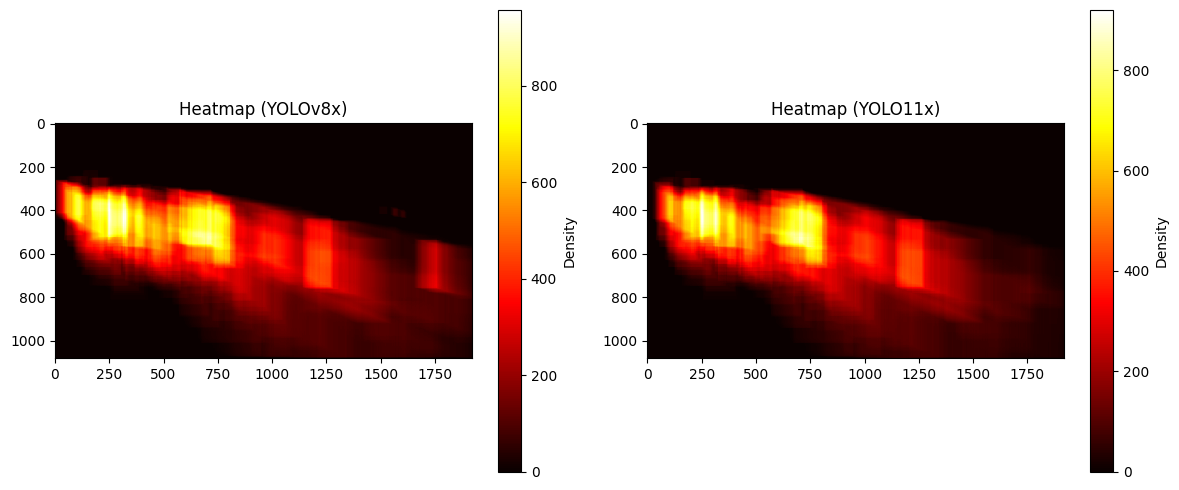


Results:
     Model       FPS  Avg People  People Std
0  YOLOv8x  0.982834   12.161702    1.427971
1  YOLO11x  1.115919   10.082270    1.379294


In [6]:
# Интерактивный график
fig = px.line(title="People Count Comparison")
for model_name in models:
    fig.add_scatter(
        x=list(range(1, len(people_per_frame[model_name]) + 1)),
        y=people_per_frame[model_name],
        name=model_name,
        mode='lines',
        hovertemplate=f"Frame: %{{x}}<br>People: %{{y}}<br>Model: {model_name}<br>Avg Confidence: %{{customdata:.2f}}",
        customdata=confidences[model_name]
    )
fig.update_layout(xaxis_title="Frame", yaxis_title="People")

# Аннотация ключевого кадра
fig.add_vline(x=max_diff_frame["number"], line_dash="dash", annotation_text="Max Diff", annotation_position="top")
fig.write_html("people_count_comparison.html")
fig.show()

# Тепловые карты
plt.figure(figsize=(12, 5))
for idx, model_name in enumerate(models, 1):
    plt.subplot(1, 2, idx)
    plt.imshow(heatmap[model_name], cmap="hot", interpolation="nearest")
    plt.colorbar(label="Density")
    plt.title(f"Heatmap ({model_name})")
plt.tight_layout()
plt.savefig("heatmaps_comparison.png")
plt.show()

# Таблица
print("\nResults:")
print(results_df)